In [1]:
import math
import numpy as np
import scipy.sparse as sp
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
import os
import numpy as np
from copy import deepcopy

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from box import Box

import warnings

warnings.filterwarnings(action='ignore')
torch.set_printoptions(sci_mode=True)

# 1. 학습 설정

In [2]:
config = {
    'data_path' : "/opt/ml/input/data/train" , # 데이터 경로
    'model_path' : "../model",


    'submission_path' : "../submission",
    'submission_name' : 'Ensembel_v11_submission.csv',

    'candidate_item_num' : 50,
    'valid_samples' : 10, # 검증에 사용할 sample 수
    'seed' : 22,
}

device = 'cuda' if torch.cuda.is_available() else 'cpu'

config = Box(config)

# 2. 데이터 전처리

In [3]:
class MakeMatrixDataSet():
    """
    MatrixDataSet 생성
    """
    def __init__(self, config):
        self.config = config
        self.df = pd.read_csv(os.path.join(self.config.data_path, 'train_ratings.csv'))
        
        self.item_encoder, self.item_decoder = self.generate_encoder_decoder('item')
        self.user_encoder, self.user_decoder = self.generate_encoder_decoder('user')
        self.num_item, self.num_user = len(self.item_encoder), len(self.user_encoder)

        self.df['item_idx'] = self.df['item'].apply(lambda x : self.item_encoder[x])
        self.df['user_idx'] = self.df['user'].apply(lambda x : self.user_encoder[x])

        self.user_train, self.user_valid = self.generate_sequence_data()

    def generate_encoder_decoder(self, col : str) -> dict:
        """
        encoder, decoder 생성

        Args:
            col (str): 생성할 columns 명
        Returns:
            dict: 생성된 user encoder, decoder
        """

        encoder = {}
        decoder = {}
        ids = self.df[col].unique()

        for idx, _id in enumerate(ids):
            encoder[_id] = idx
            decoder[idx] = _id

        return encoder, decoder
    
    def generate_sequence_data(self) -> dict:
        """
        sequence_data 생성

        Returns:
            dict: train user sequence / valid user sequence
        """
        users = defaultdict(list)
        user_train = {}
        user_valid = {}
        for user, item, time in zip(self.df['user_idx'], self.df['item_idx'], self.df['time']):
            users[user].append(item)
        
        for user in users:
            np.random.seed(self.config.seed)

            user_total = users[user]
            valid = np.random.choice(user_total, size = self.config.valid_samples, replace = False).tolist()
            train = list(set(user_total) - set(valid))

            user_train[user] = train
            user_valid[user] = valid # valid_samples 개수 만큼 검증에 활용 (현재 Task와 가장 유사하게)

        return user_train, user_valid
    
    def get_train_valid_data(self):
        return self.user_train, self.user_valid

    def make_matrix(self, user_list, train = True):
        """
        user_item_dict를 바탕으로 행렬 생성
        """
        mat = torch.zeros(size = (user_list.size(0), self.num_item))
        for idx, user in enumerate(user_list):
            if train:
                mat[idx, self.user_train[user.item()]] = 1
            else:
                mat[idx, self.user_train[user.item()] + self.user_valid[user.item()]] = 1
        return mat

    def make_sparse_matrix(self, test = False):
        X = sp.dok_matrix((self.num_user, self.num_item), dtype=np.float32)
        
        for user in self.user_train.keys():
            item_list = self.user_train[user]
            X[user, item_list] = 1.0
        
        if test:
            for user in self.user_valid.keys():
                item_list = self.user_valid[user]
                X[user, item_list] = 1.0

        return X.tocsr()

In [4]:
class AEDataSet(Dataset):
    def __init__(self, num_user):
        self.num_user = num_user
        self.users = [i for i in range(num_user)]

    def __len__(self):
        return self.num_user

    def __getitem__(self, idx): 
        user = self.users[idx]
        return torch.LongTensor([user])

# 3. 모델

In [5]:
class HOSLIM():
    def __init__(self, threshold = 3500, lambdaBB = 500, lambdaCC = 5000, rho = 100000, epochs = 40):
        self.threshold = threshold
        self.lambdaBB = lambdaBB
        self.lambdaCC = lambdaCC
        self.rho = rho
        self.epochs = epochs
    
    def create_list_feature_pairs(self, XtX):
        AA = np.triu(np.abs(XtX))
        AA[ np.diag_indices(AA.shape[0]) ]=0.0
        ii_pairs = np.where((AA > self.threshold) == True)
        return ii_pairs
    
    def create_matrix_Z(self, ii_pairs, X):
        MM = np.zeros( (len(ii_pairs[0]), X.shape[1]),    dtype=np.float)
        MM[np.arange(MM.shape[0]) , ii_pairs[0]   ]=1.0
        MM[np.arange(MM.shape[0]) , ii_pairs[1]   ]=1.0
        CCmask = 1.0-MM
        MM = MM.T
        Z=  X.dot(MM)
        Z= (Z == 2.0 )
        Z=Z*1.0
        return Z, CCmask

    def train_higher(self, XtX, XtXdiag, ZtZ, ZtZdiag, CCmask, ZtX):
        ii_diag=np.diag_indices(XtX.shape[0])
        XtX[ii_diag] = XtXdiag + self.lambdaBB
        PP = np.linalg.inv(XtX)
        ii_diag_ZZ=np.diag_indices(ZtZ.shape[0])
        ZtZ[ii_diag_ZZ] = ZtZdiag + self.lambdaCC + self.rho
        QQ=np.linalg.inv(ZtZ)
        CC = np.zeros( (ZtZ.shape[0], XtX.shape[0]),dtype=np.float )
        DD = np.zeros( (ZtZ.shape[0], XtX.shape[0]),dtype=np.float )
        UU = np.zeros( (ZtZ.shape[0], XtX.shape[0]),dtype=np.float )

        for iter in range(self.epochs):
            # learn BB
            XtX[ii_diag] = XtXdiag
            BB= PP.dot(XtX-ZtX.T.dot(CC))
            gamma = np.diag(BB) / np.diag(PP)
            BB-= PP * gamma
            # learn CC
            CC= QQ.dot(ZtX-ZtX.dot(BB) + self.rho * (DD-UU))
            # learn DD
            DD=  CC  * CCmask 
            #DD= np.maximum(0.0, DD) # if you want to enforce non-negative parameters
            # learn UU (is Gamma in paper)
            UU+= CC-DD
        
        return BB, DD

    def fit(self, X):
        XtX = X.T.dot(X)
        XtXdiag = deepcopy(np.diag(XtX))
        ii_pairs = self.create_list_feature_pairs(XtX)
        Z, CCmask = self.create_matrix_Z(ii_pairs, X)

        ZtZ = Z.T.dot(Z)
        ZtZdiag = deepcopy(np.diag(ZtZ))

        ZtX = Z.T.dot(X)

        BB, CC = self.train_higher(XtX, XtXdiag, ZtZ, ZtZdiag, CCmask, ZtX)

        self.pred = torch.from_numpy(X.dot(BB) + Z.dot(CC))

In [6]:
class AdmmSlim():
    def __init__(self, lambda_1=1, lambda_2=500, rho=10000, positive=True, n_iter=50, eps_rel=1e-4, eps_abs=1e-3, verbose=False):
        self.lambda_1 = lambda_1
        self.lambda_2 = lambda_2
        self.rho = rho
        self.positive = positive
        self.n_iter = n_iter
        self.eps_rel = eps_rel
        self.eps_abs = eps_abs
        self.verbose = verbose
    
    def soft_thresholding(self, B, Gamma):
        if self.lambda_1 == 0:
            if self.positive:
                return np.abs(B)
            else:
                return B
        else:
            x = B + Gamma / self.rho
            threshold = self.lambda_1 / self.rho
            if self.positive:
                return np.where(threshold < x, x - threshold, 0)
            else:
                return np.where(threshold < x, x - threshold,
                                np.where(x < - threshold, x + threshold, 0))

    def is_converged(self, B, C, C_old, Gamma):
        B_norm = np.linalg.norm(B)
        C_norm = np.linalg.norm(C)
        Gamma_norm = np.linalg.norm(Gamma)

        eps_primal = self.eps_abs * B.shape[0] - self.eps_rel * np.max([B_norm, C_norm])
        eps_dual = self.eps_abs * B.shape[0] - self.eps_rel * Gamma_norm

        R_primal_norm = np.linalg.norm(B - C)
        R_dual_norm = np.linalg.norm(C  - C_old) * self.rho

        converged = R_primal_norm < eps_primal and R_dual_norm < eps_dual
        return converged

    def fit(self, X):
        XtX = X.T.dot(X)
        if sp.issparse(XtX):
            XtX = XtX.todense().A

        if self.verbose:
            print(' --- init')
        identity_mat = np.identity(XtX.shape[0])
        diags = identity_mat * (self.lambda_2 + self.rho)
        P = np.linalg.inv(XtX + diags).astype(np.float32)
        B_aux = P.dot(XtX)

        Gamma = np.zeros_like(XtX, dtype=np.float32)
        C = np.zeros_like(XtX, dtype=np.float32)

        if self.verbose:
            print(' --- iteration start.')
        for iter in range(self.n_iter):
            if self.verbose:
                print(f' --- iteration {iter+1}/{self.n_iter}')
            C_old = C.copy()
            B_tilde = B_aux + P.dot(self.rho * C - Gamma)
            gamma = np.diag(B_tilde) / (np.diag(P) + 1e-8)
            B = B_tilde - P * gamma
            C = self.soft_thresholding(B, Gamma)
            Gamma = Gamma + self.rho * (B - C)
            if self.is_converged(B, C, C_old, Gamma):
                if self.verbose:
                    print(f' --- Converged. Stopped iteration.')
                break

        coef = C

        self.pred = torch.from_numpy(X.dot(coef))

In [7]:
class MultiVAE(nn.Module):
    """
    Container module for Multi-DAE.

    Multi-DAE : Denoising Autoencoder with Multinomial Likelihood
    See Variational Autoencoders for Collaborative Filtering
    https://arxiv.org/abs/1802.05814
    """

    def __init__(self, p_dims, dropout_rate = 0.5):
        super(MultiVAE, self).__init__()
        self.p_dims = p_dims
        self.q_dims = p_dims[::-1]

        temp_q_dims = self.q_dims[:-1] + [self.q_dims[-1] * 2]

        self.q_layers = nn.ModuleList([nn.Linear(d_in, d_out) for
            d_in, d_out in zip(temp_q_dims[:-1], temp_q_dims[1:])])

        self.p_layers = nn.ModuleList([nn.Linear(d_in, d_out) for
            d_in, d_out in zip(self.p_dims[:-1], self.p_dims[1:])])

        self.drop = nn.Dropout(dropout_rate)
        self.init_weights()
    
    def forward(self, input):
        mu, logvar = self.encode(input)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    
    def encode(self, input):
        h = F.normalize(input)
        h = self.drop(h)

        for i, layer in enumerate(self.q_layers):
            h = layer(h)
            if i != len(self.q_layers) - 1:
                h = F.tanh(h)
            else:
                mu = h[:, :self.q_dims[-1]]
                logvar = h[:, self.q_dims[-1]:]
        return mu, logvar

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu
    
    def decode(self, z):
        h = z
        for i, layer in enumerate(self.p_layers):
            h = layer(h)
            if i != len(self.p_layers) - 1:
                h = F.tanh(h)
        return h

    def init_weights(self):
        for layer in self.q_layers:
            # Xavier Initialization for weights
            size = layer.weight.size()
            fan_out = size[0]
            fan_in = size[1]
            std = np.sqrt(2.0/(fan_in + fan_out))
            layer.weight.data.normal_(0.0, std)

            # Normal Initialization for Biases
            layer.bias.data.normal_(0.0, 0.001)
        
        for layer in self.p_layers:
            # Xavier Initialization for weights
            size = layer.weight.size()
            fan_out = size[0]
            fan_in = size[1]
            std = np.sqrt(2.0/(fan_in + fan_out))
            layer.weight.data.normal_(0.0, std)

            # Normal Initialization for Biases
            layer.bias.data.normal_(0.0, 0.001)

In [8]:
class MultiDAE(nn.Module):
    """
    Container module for Multi-DAE.

    Multi-DAE : Denoising Autoencoder with Multinomial Likelihood
    See Variational Autoencoders for Collaborative Filtering
    https://arxiv.org/abs/1802.05814
    """

    def __init__(self, p_dims, dropout_rate = 0.5):
        super(MultiDAE, self).__init__()
        self.p_dims = p_dims
        self.q_dims = p_dims[::-1]

        self.dims = self.q_dims + self.p_dims[1:]
        self.layers = nn.ModuleList([nn.Linear(d_in, d_out) for
            d_in, d_out in zip(self.dims[:-1], self.dims[1:])])
        self.drop = nn.Dropout(dropout_rate)
        
        self.init_weights()
    
    def forward(self, input):
        h = F.normalize(input)
        h = self.drop(h)

        for i, layer in enumerate(self.layers):
            h = layer(h)
            if i != len(self.layers) - 1:
                h = F.tanh(h)
        return h

    def init_weights(self):
        for layer in self.layers:
            # Xavier Initialization for weights
            size = layer.weight.size()
            fan_out = size[0]
            fan_in = size[1]
            std = np.sqrt(2.0/(fan_in + fan_out))
            layer.weight.data.normal_(0.0, std)

            # Normal Initialization for Biases
            layer.bias.data.normal_(0.0, 0.001)

In [9]:
class AutoRec(nn.Module):
    def __init__(self, num, num_factor):
        super(AutoRec, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(num, num_factor),
            nn.Sigmoid(),
            nn.Linear(num_factor, num_factor // 2),
        )
        self.decoder = nn.Sequential(
            nn.Linear(num_factor // 2, num_factor),
            nn.Sigmoid(),
            nn.Linear(num_factor, num),
        )

        self.init_weights()

    def forward(self, mat):
        latent = self.encoder(mat)
        recont_mat = self.decoder(latent)

        return recont_mat

    def init_weights(self):
        for layer in self.encoder:
            if isinstance(layer, nn.Linear):
                size = layer.weight.size()
                fan_out = size[0]
                fan_in = size[1]
                std = np.sqrt(2.0/(fan_in + fan_out))
                layer.weight.data.normal_(0.0, std)
                layer.bias.data.normal_(0.0, 0.001)
        
        for layer in self.decoder:
            if isinstance(layer, nn.Linear):
                size = layer.weight.size()
                fan_out = size[0]
                fan_in = size[1]
                std = np.sqrt(2.0/(fan_in + fan_out))
                layer.weight.data.normal_(0.0, std)
                layer.bias.data.normal_(0.0, 0.001)

In [10]:
class EASE():
    def __init__(self, X, reg):
        self.X = self._convert_sp_mat_to_sp_tensor(X)
        self.reg = reg
    
    def _convert_sp_mat_to_sp_tensor(self, X):
        """
        Convert scipy sparse matrix to PyTorch sparse matrix

        Arguments:
        ----------
        X = Adjacency matrix, scipy sparse matrix
        """
        coo = X.tocoo().astype(np.float32)
        i = torch.LongTensor(np.mat([coo.row, coo.col]))
        v = torch.FloatTensor(coo.data)
        res = torch.sparse.FloatTensor(i, v, coo.shape).to(device)
        return res
    
    def fit(self):
        '''

        진짜 정말 간단한 식으로 모델을 만듬

        '''
        G = self.X.to_dense().t() @ self.X.to_dense()
        diagIndices = torch.eye(G.shape[0]) == 1
        G[diagIndices] += self.reg

        P = G.inverse()
        B = P / (-1 * P.diag())
        B[diagIndices] = 0

        self.pred = self.X.to_dense() @ B

In [11]:
def swish(x):
    return x.mul(torch.sigmoid(x))

def log_norm_pdf(x, mu, logvar):
    return -0.5*(logvar + np.log(2 * np.pi) + (x - mu).pow(2) / logvar.exp())

class CompositePrior(nn.Module):
    def __init__(self, hidden_dim, latent_dim, input_dim, mixture_weights=[3/20, 3/4, 1/10]):
        super(CompositePrior, self).__init__()
        
        self.mixture_weights = mixture_weights
        
        self.mu_prior = nn.Parameter(torch.Tensor(1, latent_dim), requires_grad=False)
        self.mu_prior.data.fill_(0)
        
        self.logvar_prior = nn.Parameter(torch.Tensor(1, latent_dim), requires_grad=False)
        self.logvar_prior.data.fill_(0)
        
        self.logvar_uniform_prior = nn.Parameter(torch.Tensor(1, latent_dim), requires_grad=False)
        self.logvar_uniform_prior.data.fill_(10)
        
        self.encoder_old = Encoder(hidden_dim, latent_dim, input_dim)
        self.encoder_old.requires_grad_(False)
        
    def forward(self, x, z):

        post_mu, post_logvar = self.encoder_old(x, dropout_rate = 0)

        stnd_prior = log_norm_pdf(z, self.mu_prior, self.logvar_prior)
        post_prior = log_norm_pdf(z, post_mu, post_logvar)
        unif_prior = log_norm_pdf(z, self.mu_prior, self.logvar_uniform_prior)
        
        gaussians = [stnd_prior, post_prior, unif_prior]
        gaussians = [g.add(np.log(w)) for g, w in zip(gaussians, self.mixture_weights)]

        density_per_gaussian = torch.stack(gaussians, dim=-1)

        return torch.logsumexp(density_per_gaussian, dim=-1)

    
class Encoder(nn.Module):
    def __init__(self, hidden_dim, latent_dim, input_dim, eps=1e-1):
        super(Encoder, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.ln1 = nn.LayerNorm(hidden_dim, eps=eps)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.ln2 = nn.LayerNorm(hidden_dim, eps=eps)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.ln3 = nn.LayerNorm(hidden_dim, eps=eps)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.ln4 = nn.LayerNorm(hidden_dim, eps=eps)
        self.fc5 = nn.Linear(hidden_dim, hidden_dim)
        self.ln5 = nn.LayerNorm(hidden_dim, eps=eps)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        
    def forward(self, x, dropout_rate):
        norm = x.pow(2).sum(dim=-1).sqrt()
        x = x / norm[:, None]
    
        x = F.dropout(x, p=dropout_rate, training=self.training)
        
        h1 = self.ln1(swish(self.fc1(x)))
        h2 = self.ln2(swish(self.fc2(h1) + h1))
        h3 = self.ln3(swish(self.fc3(h2) + h1 + h2))
        h4 = self.ln4(swish(self.fc4(h3) + h1 + h2 + h3))
        h5 = self.ln5(swish(self.fc5(h4) + h1 + h2 + h3 + h4))
        return self.fc_mu(h5), self.fc_logvar(h5)


class RecVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim = 600, latent_dim = 200):
        super(RecVAE, self).__init__()

        self.encoder = Encoder(hidden_dim, latent_dim, input_dim)
        self.prior = CompositePrior(hidden_dim, latent_dim, input_dim)
        self.decoder = nn.Linear(latent_dim, input_dim)
        
    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5*logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu

    def forward(self, user_ratings, beta=None, gamma=0.0005, dropout_rate=0.7, calculate_loss=True):
        mu, logvar = self.encoder(user_ratings, dropout_rate=dropout_rate)    
        z = self.reparameterize(mu, logvar)
        x_pred = self.decoder(z)

        if calculate_loss:
            if gamma:
                norm = user_ratings.sum(dim=-1)
                kl_weight = gamma * norm
            elif beta:
                kl_weight = beta

            mll = (F.log_softmax(x_pred, dim=-1) * user_ratings).sum(dim=-1).mean()
            kld = (log_norm_pdf(z, mu, logvar) - self.prior(user_ratings, z)).sum(dim=-1).mul(kl_weight).mean()
            negative_elbo = -(mll - kld)
            
            return (mll, kld), negative_elbo
            
        else:
            return x_pred

    def update_prior(self):
        self.prior.encoder_old.load_state_dict(deepcopy(self.encoder.state_dict()))

# 4. 학습 함수

In [12]:
def get_ndcg(pred_list, true_list):
    idcg = sum((1 / np.log2(rank + 2) for rank in range(1, len(pred_list))))
    dcg = 0
    for rank, pred in enumerate(pred_list):
        if pred in true_list:
            dcg += 1 / np.log2(rank + 2)
    ndcg = dcg / idcg
    return ndcg

# hit == recall == precision
def get_hit(pred_list, true_list):
    hit_list = set(true_list) & set(pred_list)
    hit = len(hit_list) / len(true_list)
    return hit

In [13]:
def evaluate(AdmmSlim, HOSLIM, RecVAE, MultiDAE, X, user_train, user_valid, candidate_cnt):
    NDCG = 0
    HIT = 0
    
    RecVAE.eval()
    # MultiVAE.eval()
    MultiDAE.eval()
    # AutoRec.eval()

    mat = torch.from_numpy(X)

    HOSLIM_recon_mat = HOSLIM.pred.cpu()
    HOSLIM_recon_mat[mat == 1] = -np.inf
    HOSLIM_rec_list = HOSLIM_recon_mat.argsort(dim = 1)

    # User_EASE_recon_mat = User_EASE.pred.cpu()
    # User_EASE_recon_mat[mat == 1] = -np.inf
    # User_EASE_rec_list = User_EASE_recon_mat.argsort(dim = 1)

    AdmmSlim_recon_mat = AdmmSlim.pred.cpu()
    AdmmSlim_recon_mat[mat == 1] = -np.inf
    AdmmSlim_rec_list = AdmmSlim_recon_mat.argsort(dim = 1)

    # Item_EASE_recon_mat = Item_EASE.pred.T.cpu()
    # Item_EASE_recon_mat[mat == 1] = -np.inf
    # Item_EASE_rec_list = Item_EASE_recon_mat.argsort(dim = 1)

    RecVAE_recon_mat = RecVAE(mat.to(device), calculate_loss = False).cpu().detach()
    RecVAE_recon_mat[mat == 1] = -np.inf
    RecVAE_rec_list = RecVAE_recon_mat.argsort(dim = 1)

    # MultiVAE_recon_mat, _, _ = MultiVAE(mat.to(device))
    # MultiVAE_recon_mat = MultiVAE_recon_mat.cpu().detach()
    # MultiVAE_recon_mat[mat == 1] = -np.inf
    # MultiVAE_rec_list = MultiVAE_recon_mat.argsort(dim = 1)

    MultiDAE_recon_mat = MultiDAE(mat.to(device)).cpu().detach()
    MultiDAE_recon_mat[mat == 1] = -np.inf
    MultiDAE_rec_list = MultiDAE_recon_mat.argsort(dim = 1)

    # AutoRec_recon_mat = AutoRec(mat.to(device)).cpu().detach()
    # AutoRec_recon_mat[mat == 1] = -np.inf
    # AutoRec_rec_list = AutoRec_recon_mat.argsort(dim = 1)

    score_li = np.array([1 / np.log2(rank + 2) for rank in range(0, candidate_cnt)])

    for user, (HOSLIM_rec, AdmmSlim_rec, RecVAE_rec, MultiDAE_rec) in tqdm(enumerate(zip(HOSLIM_rec_list, AdmmSlim_rec_list, RecVAE_rec_list, MultiDAE_rec_list))):
        
        uv = user_valid[user]

        # ranking
        HOSLIM_rec = HOSLIM_rec[-candidate_cnt:].cpu().numpy().tolist()[::-1]
        # User_EASE_rec = User_EASE_rec[-candidate_cnt:].cpu().numpy().tolist()[::-1]
        # Item_EASE_rec = Item_EASE_rec[-candidate_cnt:].cpu().numpy().tolist()[::-1]
        AdmmSlim_rec = AdmmSlim_rec[-candidate_cnt:].cpu().numpy().tolist()[::-1]
        RecVAE_rec = RecVAE_rec[-candidate_cnt:].cpu().numpy().tolist()[::-1]
        # MultiVAE_rec = MultiVAE_rec[-candidate_cnt:].cpu().numpy().tolist()[::-1]
        MultiDAE_rec = MultiDAE_rec[-candidate_cnt:].cpu().numpy().tolist()[::-1]
        # AutoRec_rec = AutoRec_rec[-candidate_cnt:].cpu().numpy().tolist()[::-1]

        all_rec = list(set(HOSLIM_rec + AdmmSlim_rec + RecVAE_rec + MultiDAE_rec))

        rec_df = pd.DataFrame(index = all_rec)
        rec_df.loc[HOSLIM_rec, 'HOSLIM_rec_score'] = score_li * 1.0
        # rec_df.loc[User_EASE_rec, 'User_EASE_rec_score'] = score_li * 0.3
        # rec_df.loc[Item_EASE_rec, 'Item_EASE_rec_score'] = score_li * 0.3
        rec_df.loc[AdmmSlim_rec, 'AdmmSlim_rec_score'] = score_li * 0.6
        rec_df.loc[RecVAE_rec, 'RecVAE_rec_score'] = score_li * 0.8
        # rec_df.loc[MultiVAE_rec, 'MultiVAE_rec_score'] = score_li * 0.3
        rec_df.loc[MultiDAE_rec, 'MultiDAE_rec_score'] = score_li * 0.3
        # rec_df.loc[AutoRec_rec, 'AutoRec_rec_score'] = score_li
        rec_df = rec_df.fillna(rec_df.min().min())

        rec_df['total_rec_score'] = rec_df.sum(axis = 1)
        rec_df = rec_df.sort_values('total_rec_score', ascending = False)
        up = rec_df.index.tolist()[:10]

        NDCG += get_ndcg(pred_list = up, true_list = uv)
        HIT += get_hit(pred_list = up, true_list = uv)

    NDCG /= len(user_train)
    HIT /= len(user_train)

    return NDCG, HIT

In [14]:
def get_total_evaluate_df(User_EASE, Item_EASE, AdmmSlim, HOSLIM, RecVAE, MultiVAE, MultiDAE, AutoRec, X, user_train, user_valid, candidate_cnt):
    total_evaluate_df = []

    RecVAE.eval()
    MultiVAE.eval()
    MultiDAE.eval()
    AutoRec.eval()

    mat = torch.from_numpy(X)
    
    User_EASE_recon_mat = User_EASE.pred.cpu()
    User_EASE_recon_mat[mat == 1] = -np.inf
    User_EASE_rec_list = User_EASE_recon_mat.argsort(dim = 1)

    Item_EASE_recon_mat = Item_EASE.pred.T.cpu()
    Item_EASE_recon_mat[mat == 1] = -np.inf
    Item_EASE_rec_list = Item_EASE_recon_mat.argsort(dim = 1)

    AdmmSlim_recon_mat = AdmmSlim.pred.cpu()
    AdmmSlim_recon_mat[mat == 1] = -np.inf
    AdmmSlim_rec_list = AdmmSlim_recon_mat.argsort(dim = 1)

    HOSLIM_recon_mat = HOSLIM.pred.cpu()
    HOSLIM_recon_mat[mat == 1] = -np.inf
    HOSLIM_rec_list = HOSLIM_recon_mat.argsort(dim = 1)

    RecVAE_recon_mat = RecVAE(mat.to(device), calculate_loss = False).cpu().detach()
    RecVAE_recon_mat[mat == 1] = -np.inf
    RecVAE_rec_list = RecVAE_recon_mat.argsort(dim = 1)

    AutoRec_recon_mat = AutoRec(mat.to(device)).cpu().detach()
    AutoRec_recon_mat[mat == 1] = -np.inf
    AutoRec_rec_list = AutoRec_recon_mat.argsort(dim = 1)

    MultiDAE_recon_mat = MultiDAE(mat.to(device)).cpu().detach()
    MultiDAE_recon_mat[mat == 1] = -np.inf
    MultiDAE_rec_list = MultiDAE_recon_mat.argsort(dim = 1)

    MultiVAE_recon_mat, _, _ = MultiVAE(mat.to(device))
    MultiVAE_recon_mat = MultiVAE_recon_mat.cpu().detach()
    MultiVAE_recon_mat[mat == 1] = -np.inf
    MultiVAE_rec_list = MultiVAE_recon_mat.argsort(dim = 1)

    for user, (User_EASE_rec, Item_EASE_rec, AdmmSlim_rec, HOSLIM_rec, RecVAE_rec, AutoRec_rec, MultiDAE_rec, MultiVAE_rec) in tqdm(enumerate(zip(User_EASE_rec_list, Item_EASE_rec_list, AdmmSlim_rec_list, HOSLIM_rec_list, RecVAE_rec_list, AutoRec_rec_list, MultiDAE_rec_list, MultiVAE_rec_list))):
        
        uv = user_valid[user]

        # ranking
        User_EASE_rec = User_EASE_rec[-candidate_cnt:].cpu().numpy().tolist()[::-1]
        Item_EASE_rec = Item_EASE_rec[-candidate_cnt:].cpu().numpy().tolist()[::-1]
        AdmmSlim_rec = AdmmSlim_rec[-candidate_cnt:].cpu().numpy().tolist()[::-1]
        HOSLIM_rec = HOSLIM_rec[-candidate_cnt:].cpu().numpy().tolist()[::-1]
        RecVAE_rec = RecVAE_rec[-candidate_cnt:].cpu().numpy().tolist()[::-1]
        AutoRec_rec = AutoRec_rec[-candidate_cnt:].cpu().numpy().tolist()[::-1]
        MultiDAE_rec = MultiDAE_rec[-candidate_cnt:].cpu().numpy().tolist()[::-1]
        MultiVAE_rec = MultiVAE_rec[-candidate_cnt:].cpu().numpy().tolist()[::-1]

        all_rec = list(set(User_EASE_rec + Item_EASE_rec + AdmmSlim_rec + HOSLIM_rec + RecVAE_rec + AutoRec_rec + MultiDAE_rec + MultiVAE_rec))

        total_evaluate_df.append(
            {
               'user' : user,
               'len' : len(all_rec),

               'User_EASE_rec_score' : get_hit(pred_list = User_EASE_rec, true_list = uv),
               'Item_EASE_rec_score' : get_hit(pred_list = Item_EASE_rec, true_list = uv),
               'AdmmSlim_rec_score' : get_hit(pred_list = AdmmSlim_rec, true_list = uv),
               'HOSLIM_rec_score' : get_hit(pred_list = HOSLIM_rec, true_list = uv),
               'RecVAE_rec_score' : get_hit(pred_list = RecVAE_rec, true_list = uv),
               'AutoRec_rec_score' : get_hit(pred_list = AutoRec_rec, true_list = uv),
               'MultiDAE_rec_score' : get_hit(pred_list = MultiDAE_rec, true_list = uv),
               'MultiVAE_rec_score' : get_hit(pred_list = MultiVAE_rec, true_list = uv),

               'all_rec_score' : get_hit(pred_list = all_rec, true_list = uv),
            }
        )

    return total_evaluate_df

In [15]:
def get_weighted_ensemble_df(User_EASE, Item_EASE, AdmmSlim, HOSLIM, RecVAE, MultiVAE, MultiDAE, AutoRec, X, candidate_cnt):
    
    weighted_ensemble_df = {}

    RecVAE.eval()
    MultiVAE.eval()
    MultiDAE.eval()
    AutoRec.eval()

    mat = torch.from_numpy(X)
    
    User_EASE_recon_mat = User_EASE.pred.cpu()
    User_EASE_recon_mat[mat == 1] = -np.inf
    User_EASE_rec_list = User_EASE_recon_mat.argsort(dim = 1)

    Item_EASE_recon_mat = Item_EASE.pred.T.cpu()
    Item_EASE_recon_mat[mat == 1] = -np.inf
    Item_EASE_rec_list = Item_EASE_recon_mat.argsort(dim = 1)

    AdmmSlim_recon_mat = AdmmSlim.pred.cpu()
    AdmmSlim_recon_mat[mat == 1] = -np.inf
    AdmmSlim_rec_list = AdmmSlim_recon_mat.argsort(dim = 1)

    HOSLIM_recon_mat = HOSLIM.pred.cpu()
    HOSLIM_recon_mat[mat == 1] = -np.inf
    HOSLIM_rec_list = HOSLIM_recon_mat.argsort(dim = 1)

    RecVAE_recon_mat = RecVAE(mat.to(device), calculate_loss = False).cpu().detach()
    RecVAE_recon_mat[mat == 1] = -np.inf
    RecVAE_rec_list = RecVAE_recon_mat.argsort(dim = 1)

    AutoRec_recon_mat = AutoRec(mat.to(device)).cpu().detach()
    AutoRec_recon_mat[mat == 1] = -np.inf
    AutoRec_rec_list = AutoRec_recon_mat.argsort(dim = 1)

    MultiDAE_recon_mat = MultiDAE(mat.to(device)).cpu().detach()
    MultiDAE_recon_mat[mat == 1] = -np.inf
    MultiDAE_rec_list = MultiDAE_recon_mat.argsort(dim = 1)

    MultiVAE_recon_mat, _, _ = MultiVAE(mat.to(device))
    MultiVAE_recon_mat = MultiVAE_recon_mat.cpu().detach()
    MultiVAE_recon_mat[mat == 1] = -np.inf
    MultiVAE_rec_list = MultiVAE_recon_mat.argsort(dim = 1)

    score_li = np.array([1 / np.log2(rank + 2) for rank in range(0, candidate_cnt)])

    for user, (User_EASE_rec, Item_EASE_rec, AdmmSlim_rec, HOSLIM_rec, RecVAE_rec, AutoRec_rec, MultiDAE_rec, MultiVAE_rec) in tqdm(enumerate(zip(User_EASE_rec_list, Item_EASE_rec_list, AdmmSlim_rec_list, HOSLIM_rec_list, RecVAE_rec_list, AutoRec_rec_list, MultiDAE_rec_list, MultiVAE_rec_list))):

        # ranking
        User_EASE_rec = User_EASE_rec[-candidate_cnt:].cpu().numpy().tolist()[::-1]
        Item_EASE_rec = Item_EASE_rec[-candidate_cnt:].cpu().numpy().tolist()[::-1]
        AdmmSlim_rec = AdmmSlim_rec[-candidate_cnt:].cpu().numpy().tolist()[::-1]
        HOSLIM_rec = HOSLIM_rec[-candidate_cnt:].cpu().numpy().tolist()[::-1]
        RecVAE_rec = RecVAE_rec[-candidate_cnt:].cpu().numpy().tolist()[::-1]
        AutoRec_rec = AutoRec_rec[-candidate_cnt:].cpu().numpy().tolist()[::-1]
        MultiDAE_rec = MultiDAE_rec[-candidate_cnt:].cpu().numpy().tolist()[::-1]
        MultiVAE_rec = MultiVAE_rec[-candidate_cnt:].cpu().numpy().tolist()[::-1]

        all_rec = list(set(User_EASE_rec + Item_EASE_rec + AdmmSlim_rec + HOSLIM_rec + RecVAE_rec + AutoRec_rec + MultiDAE_rec + MultiVAE_rec))

        rec_df = pd.DataFrame(index = all_rec)
        rec_df.loc[User_EASE_rec, 'User_EASE_rec_score'] = score_li
        rec_df.loc[Item_EASE_rec, 'Item_EASE_rec_score'] = score_li
        rec_df.loc[AdmmSlim_rec, 'AdmmSlim_rec_score'] = score_li
        rec_df.loc[HOSLIM_rec, 'HOSLIM_rec_score'] = score_li
        rec_df.loc[RecVAE_rec, 'RecVAE_rec_score'] = score_li
        rec_df.loc[AutoRec_rec, 'AutoRec_rec_score'] = score_li
        rec_df.loc[MultiDAE_rec, 'MultiDAE_rec_score'] = score_li
        rec_df.loc[MultiVAE_rec, 'MultiVAE_rec_score'] = score_li

        weighted_ensemble_df[user] = rec_df

    return weighted_ensemble_df

# 5. 평가

## 5-1. 모델 init

In [16]:
make_matrix_data_set = MakeMatrixDataSet(config = config)
user_train, user_valid = make_matrix_data_set.get_train_valid_data()
X = make_matrix_data_set.make_sparse_matrix()

In [17]:
# hoslim = HOSLIM(threshold = 3500, lambdaBB = 500, lambdaCC = 10000, rho = 50000)
# hoslim.fit(X = X.toarray())

hoslim = HOSLIM(threshold = 3500, lambdaBB = 500, lambdaCC = 15000, rho = 10000)
hoslim.fit(X = X.toarray())

```

threshold = 3500, lambdaBB = 500, lambdaCC = 15000, rho = 10000 | NDCG@10: 0.31118| HIT@10: 0.20455

```

In [18]:
# admm_slim = AdmmSlim(lambda_2 = 1, rho = 1000)
# admm_slim.fit(X = X.toarray())

admm_slim = AdmmSlim(lambda_1 = 10, lambda_2 = 5, rho = 1000)
admm_slim.fit(X = X.toarray())

```
lambda_1 = 10, lambda_2 = 5, rho = 1000 | NDCG@10: 0.30627| HIT@10: 0.20035

```

In [19]:
# user_ease = EASE(X = X, reg = 750)
# user_ease.fit()

user_ease = EASE(X = X, reg = 680)
user_ease.fit()

```
reg: 680| NDCG@10: 0.23002| HIT@10: 0.20400
```

In [20]:
item_ease = EASE(X = X.T, reg = 4400)
item_ease.fit()

In [38]:
rec_vae = RecVAE(
    input_dim = make_matrix_data_set.num_item,
    latent_dim = 200).to(device)

rec_vae.load_state_dict(torch.load(os.path.join(config.model_path, 'RecVAE_v3_1_best.pt')))

<All keys matched successfully>

```
RecVAE_v3 | 0.192140

Multi-DAE_v2 | 0.179330

Multi-VAE_v2 | 0.179959
```

In [39]:
auto_rec = AutoRec(
    num = make_matrix_data_set.num_item, 
    num_factor = 64).to(device)

auto_rec.load_state_dict(torch.load(os.path.join(config.model_path, 'AutoRec_v1.pt')))

<All keys matched successfully>

In [40]:
multi_dae = MultiDAE(
    p_dims = [200, 600] + [make_matrix_data_set.num_item], 
    dropout_rate = 0.5).to(device)

multi_dae.load_state_dict(torch.load(os.path.join(config.model_path, 'Multi-DAE_v3.pt')))

<All keys matched successfully>

In [41]:
multi_vae = MultiVAE(
    p_dims = [200, 600] + [make_matrix_data_set.num_item], 
    dropout_rate = 0.7).to(device)

multi_vae.load_state_dict(torch.load(os.path.join(config.model_path, 'Multi-VAE_v4.pt')))

<All keys matched successfully>

## 5-2. total_evaluate

In [42]:
total_evaluate_df = get_total_evaluate_df(
    User_EASE = user_ease, 
    Item_EASE = item_ease, 
    AdmmSlim = admm_slim, 
    HOSLIM = hoslim, 
    RecVAE = rec_vae, 
    MultiVAE = multi_vae, 
    MultiDAE = multi_dae, 
    AutoRec = auto_rec,
    X = X.todense(), 
    user_train = user_train, 
    user_valid = user_valid, 
    candidate_cnt = 10)

In [ ]:
total_evaluate_df = pd.DataFrame(total_evaluate_df)

def get_total_name(x):
    val_list = [x['User_EASE_rec_score'], x['Item_EASE_rec_score'], x['AdmmSlim_rec_score'], x['HOSLIM_rec_score'], x['RecVAE_rec_score'], x['AutoRec_rec_score'], x['MultiDAE_rec_score'], x['MultiVAE_rec_score']]
    max_val = max(val_list)
    val_idx = val_list.index(max_val)
    if val_idx == 0 : return 'User_EASE_rec_score'
    elif val_idx == 1 : return 'Item_EASE_rec_score'
    elif val_idx == 2 : return 'AdmmSlim_rec_score'
    elif val_idx == 3 : return 'HOSLIM_rec_score'
    elif val_idx == 4 : return 'RecVAE_rec_score'
    elif val_idx == 5 : return 'AutoRec_rec_score'
    elif val_idx == 6 : return 'MultiDAE_rec_score'
    elif val_idx == 7 : return 'MultiVAE_rec_score'

total_evaluate_df['total_best_rec_score'] = total_evaluate_df.apply(lambda x: max(x['User_EASE_rec_score'], x['Item_EASE_rec_score'], x['AdmmSlim_rec_score'], x['HOSLIM_rec_score'], x['RecVAE_rec_score'], x['AutoRec_rec_score'], x['MultiDAE_rec_score'], x['MultiVAE_rec_score']), axis = 1)
total_evaluate_df['total_best_rec_score_name'] = total_evaluate_df.apply(lambda x: get_total_name(x), axis = 1)

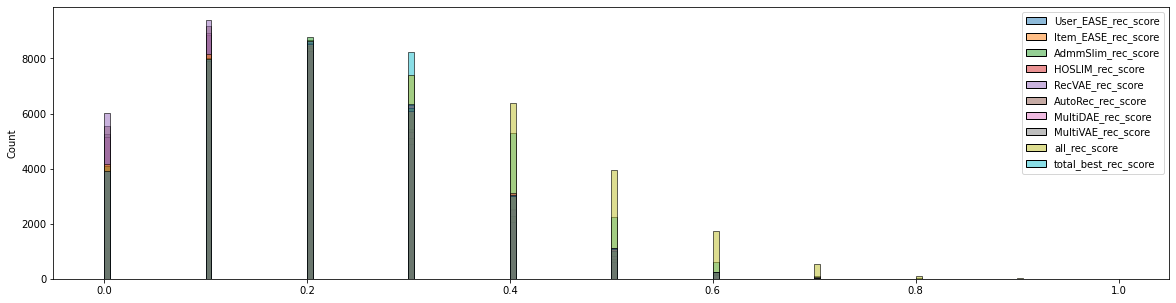

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

cols = total_evaluate_df.columns.tolist()[2:-1]

plt.figure(figsize = (20, 5))
sns.histplot(data = total_evaluate_df[cols])
plt.show()

In [ ]:
total_evaluate_df['total_best_rec_score_name'].value_counts()

User_EASE_rec_score    14955
Item_EASE_rec_score     3846
AdmmSlim_rec_score      3534
RecVAE_rec_score        2480
MultiDAE_rec_score      2068
MultiVAE_rec_score      1815
AutoRec_rec_score       1709
HOSLIM_rec_score         953
Name: total_best_rec_score_name, dtype: int64

In [ ]:
total_evaluate_df.mean()

user                    15679.500000
len                        24.937596
User_EASE_rec_score         0.204002
Item_EASE_rec_score         0.200207
AdmmSlim_rec_score          0.200351
HOSLIM_rec_score            0.204554
RecVAE_rec_score            0.168103
AutoRec_rec_score           0.174758
MultiDAE_rec_score          0.182293
MultiVAE_rec_score          0.182465
all_rec_score               0.316706
total_best_rec_score        0.267879
dtype: float64

```
len                        24.976467
User_EASE_rec_score         0.204002
Item_EASE_rec_score         0.200207
AdmmSlim_rec_score          0.200351
HOSLIM_rec_score            0.204554
RecVAE_rec_score            0.193332
AutoRec_rec_score           0.174758
MultiDAE_rec_score          0.182293
MultiVAE_rec_score          0.182465
all_rec_score               0.320619
total_best_rec_score        0.271078
```

```

len                        25.295663
User_EASE_rec_score         0.203839
Item_EASE_rec_score         0.200207
AdmmSlim_rec_score          0.200236
HOSLIM_rec_score            0.204423
RecVAE_rec_score            0.192140
AutoRec_rec_score           0.174758
MultiDAE_rec_score          0.179330
MultiVAE_rec_score          0.179959
all_rec_score               0.321936
total_best_rec_score        0.271237

```

## 5-3. evaluate

In [ ]:
for candidate_cnt in [5 * i for i in range(2, 11)]:
    
    ndcg, hit = evaluate(
        # User_EASE = user_ease, 
        # Item_EASE = item_ease, 
        AdmmSlim = admm_slim, 
        HOSLIM = hoslim,
        RecVAE = rec_vae, 
        # MultiVAE = multi_vae, 
        MultiDAE = multi_dae, 
        # AutoRec = auto_rec,
        X = X.todense(), 
        user_train = user_train, 
        user_valid = user_valid,
        candidate_cnt = candidate_cnt)

    print(f'candidate_cnt: {candidate_cnt}| NDCG@10: {ndcg:.5f}| HIT@10: {hit:.5f}')

In [ ]:
for candidate_cnt in [5 * i for i in range(2, 11)]:
    
    ndcg, hit = evaluate(
        # User_EASE = user_ease, 
        # Item_EASE = item_ease, 
        AdmmSlim = admm_slim, 
        HOSLIM = hoslim,
        RecVAE = rec_vae, 
        # MultiVAE = multi_vae, 
        MultiDAE = multi_dae, 
        # AutoRec = auto_rec,
        X = X.todense(), 
        user_train = user_train, 
        user_valid = user_valid,
        candidate_cnt = candidate_cnt)

    print(f'candidate_cnt: {candidate_cnt}| NDCG@10: {ndcg:.5f}| HIT@10: {hit:.5f}')

## 5-4. get_weighted_ensemble_df

In [33]:
weighted_ensemble_df = get_weighted_ensemble_df(
    User_EASE = user_ease, 
    Item_EASE = item_ease, 
    AdmmSlim = admm_slim, 
    HOSLIM = hoslim, 
    RecVAE = rec_vae, 
    MultiVAE = multi_vae, 
    MultiDAE = multi_dae, 
    AutoRec = auto_rec,
    X = X.todense(),
    candidate_cnt = 30)

31360it [02:53, 180.74it/s]


In [83]:
'''
1. rank sum 제일 낮은 순
2. rank sum mean 제일 낮은 순

3. 1/rank sum 제일 높은 순
4. 1/rank sum mean 제일 높은 순

5. 1 / log(rank + 1) sum 제일 높은 순
6. 1 / log(rank + 1) sum mean 제일 높은 순

7. 선별 model + 위 과정
8. 선별 model + 각 모델별 가중치 + 위 과정
'''


pd.set_option('display.max_rows', 20)

def get_rank_score(x):
    if pd.isna(x) : return x
    else: return 1 / x

def get_log_rank_score(x):
    if pd.isna(x) : return x
    else: return 1 / np.log2(x + 1)

# cols : ['HOSLIM_rec_score', 'AdmmSlim_rec_score', 'RecVAE_rec_score', 'MultiDAE_rec_score']| 
# weighte : [1.0, 0.6, 0.8, 0.3]| NDCG@10: 0.32295| HIT@10: 0.21271

df = weighted_ensemble_df[0].copy()
cols = df.columns
log_rank_score_cols = []
rank_score_cols = []
for col in cols:
    df['rank_score_'+col] = df[col].apply(lambda x : get_rank_score(x))
    rank_score_cols.append('rank_score_'+col)

    df['log_rank_score_'+col] = df[col].apply(lambda x : get_log_rank_score(x))
    log_rank_score_cols.append('log_rank_score_'+col)

uv = user_valid[0]
up = df.index.tolist()
target = list(set(uv) & set(up))

rank_score_df = df[rank_score_cols]
log_rank_score_df = df[log_rank_score_cols]
df = df[cols]

rank_score_df = rank_score_df.fillna(rank_score_df.min().min())
rank_score_df['rank_sum_total'] = rank_score_df[rank_score_cols].sum(axis = 1)
rank_score_df['rank_mean_total'] = rank_score_df[rank_score_cols].mean(axis = 1)

log_rank_score_df = log_rank_score_df.fillna(log_rank_score_df.min().min())
log_rank_score_df['log_rank_sum_total'] = log_rank_score_df[log_rank_score_cols].sum(axis = 1)
log_rank_score_df['log_rank_mean_total'] = log_rank_score_df[log_rank_score_cols].mean(axis = 1)

df = df.fillna(df.max().max())
df['sum_total'] = df[cols].sum(axis = 1)
df['mean_total'] = df[cols].mean(axis = 1)

df = pd.concat([df, rank_score_df, log_rank_score_df], axis = 1)

df = df[['sum_total', 'mean_total', 'rank_sum_total', 'rank_mean_total', 'log_rank_sum_total', 'log_rank_mean_total']]

df = df.sort_values('sum_total', ascending = True)
df['sum_total_rank'] = df.reset_index().index.values + 1

df = df.sort_values('mean_total', ascending = True)
df['mean_total_rank'] = df.reset_index().index.values + 1

df = df.sort_values('rank_sum_total', ascending = False)
df['rank_sum_total_rank'] = df.reset_index().index.values + 1

df = df.sort_values('rank_mean_total', ascending = False)
df['rank_mean_total_rank'] = df.reset_index().index.values + 1

df = df.sort_values('log_rank_sum_total', ascending = False)
df['log_rank_sum_total_rank'] = df.reset_index().index.values + 1

df = df.sort_values('log_rank_mean_total', ascending = False)
df['log_rank_mean_total_rank'] = df.reset_index().index.values + 1

df.loc[target, 'target'] = 1
df.sort_values('target', ascending = True)[:20]

,sum_total,mean_total,rank_sum_total,rank_mean_total,log_rank_sum_total,log_rank_mean_total,sum_total_rank,mean_total_rank,rank_sum_total_rank,rank_mean_total_rank,log_rank_sum_total_rank,log_rank_mean_total_rank,target
197,77.0,9.625,1.890000,0.236250,3.249907,0.406238,4,4,4,4,4,4,1.0
273,89.0,11.125,1.016807,0.127101,2.482270,0.310284,6,6,8,8,7,7,1.0
313,103.0,12.875,0.885684,0.110710,2.348951,0.293619,8,8,12,12,10,10,1.0
42,160.0,20.000,0.671620,0.083953,2.104386,0.263048,13,13,14,14,14,14,1.0
228,156.0,19.500,0.577337,0.072167,2.015265,0.251908,11,11,16,16,16,16,1.0
147,353.0,44.125,0.198256,0.024782,1.478949,0.184869,56,56,55,55,57,57,1.0
933,20.0,2.500,6.424242,0.803030,6.778943,0.847368,1,1,1,1,1,1,NaN
667,55.0,6.875,2.464286,0.308036,3.691374,0.461422,2,2,2,2,2,2,NaN
484,76.0,9.500,2.386667,0.298333,3.668348,0.458543,3,3,3,3,3,3,NaN
376,92.0,11.500,1.471739,0.183967,2.889752,0.361219,7,7,5,5,5,5,NaN


In [84]:
pd.set_option('display.max_rows', 20)

def get_rank_score(x):
    if pd.isna(x) : return x
    else: return 1 / x

def get_log_rank_score(x):
    if pd.isna(x) : return x
    else: return 1 / np.log2(x + 1)

# cols : ['HOSLIM_rec_score', 'AdmmSlim_rec_score', 'RecVAE_rec_score', 'MultiDAE_rec_score']| 
# weighte : [1.0, 0.6, 0.8, 0.3]| NDCG@10: 0.32295| HIT@10: 0.21271

df = weighted_ensemble_df[0].copy()
cols = [col for col in df.columns if col in ['HOSLIM_rec_score', 'AdmmSlim_rec_score', 'RecVAE_rec_score', 'MultiDAE_rec_score']]
log_rank_score_cols = []
rank_score_cols = []
for col in cols:
    df['rank_score_'+col] = df[col].apply(lambda x : get_rank_score(x))
    rank_score_cols.append('rank_score_'+col)

    df['log_rank_score_'+col] = df[col].apply(lambda x : get_log_rank_score(x))
    log_rank_score_cols.append('log_rank_score_'+col)

uv = user_valid[0]
up = df.index.tolist()
target = list(set(uv) & set(up))

rank_score_df = df[rank_score_cols]
log_rank_score_df = df[log_rank_score_cols]
df = df[cols]

rank_score_df = rank_score_df.fillna(rank_score_df.min().min())
rank_score_df['rank_sum_total'] = rank_score_df[rank_score_cols].sum(axis = 1)
rank_score_df['rank_mean_total'] = rank_score_df[rank_score_cols].mean(axis = 1)

log_rank_score_df = log_rank_score_df.fillna(log_rank_score_df.min().min())
log_rank_score_df['log_rank_sum_total'] = log_rank_score_df[log_rank_score_cols].sum(axis = 1)
log_rank_score_df['log_rank_mean_total'] = log_rank_score_df[log_rank_score_cols].mean(axis = 1)

df = df.fillna(df.max().max())
df['sum_total'] = df[cols].sum(axis = 1)
df['mean_total'] = df[cols].mean(axis = 1)

df = pd.concat([df, rank_score_df, log_rank_score_df], axis = 1)

df = df[['sum_total', 'mean_total', 'rank_sum_total', 'rank_mean_total', 'log_rank_sum_total', 'log_rank_mean_total']]

df = df.sort_values('sum_total', ascending = True)
df['sum_total_rank'] = df.reset_index().index.values + 1

df = df.sort_values('mean_total', ascending = True)
df['mean_total_rank'] = df.reset_index().index.values + 1

df = df.sort_values('rank_sum_total', ascending = False)
df['rank_sum_total_rank'] = df.reset_index().index.values + 1

df = df.sort_values('rank_mean_total', ascending = False)
df['rank_mean_total_rank'] = df.reset_index().index.values + 1

df = df.sort_values('log_rank_sum_total', ascending = False)
df['log_rank_sum_total_rank'] = df.reset_index().index.values + 1

df = df.sort_values('log_rank_mean_total', ascending = False)
df['log_rank_mean_total_rank'] = df.reset_index().index.values + 1

df.loc[target, 'target'] = 1
df.sort_values('target', ascending = True)[:20]

,sum_total,mean_total,rank_sum_total,rank_mean_total,log_rank_sum_total,log_rank_mean_total,sum_total_rank,mean_total_rank,rank_sum_total_rank,rank_mean_total_rank,log_rank_sum_total_rank,log_rank_mean_total_rank,target
197,42.0,10.50,0.816667,0.204167,1.519378,0.379845,6,6,5,5,5,5,1.0
313,50.0,12.50,0.405556,0.101389,1.142500,0.285625,9,9,10,10,10,10,1.0
273,49.0,12.25,0.397076,0.099269,1.138615,0.284654,8,8,12,12,11,11,1.0
42,68.0,17.00,0.346726,0.086682,1.071282,0.267820,12,12,13,13,14,14,1.0
228,62.0,15.50,0.299573,0.074893,1.031578,0.257895,11,11,16,16,15,15,1.0
147,153.0,38.25,0.118256,0.029564,0.773783,0.193446,35,35,37,37,37,37,1.0
933,14.0,3.50,3.090909,0.772727,3.278943,0.819736,2,2,1,1,1,1,NaN
484,13.0,3.25,1.500000,0.375000,2.118067,0.529517,1,1,2,2,2,2,NaN
667,30.0,7.50,1.488095,0.372024,2.026196,0.506549,4,4,3,3,3,3,NaN
376,21.0,5.25,0.933333,0.233333,1.650418,0.412604,3,3,4,4,4,4,NaN


In [85]:
pd.set_option('display.max_rows', 20)

def get_rank_score(x):
    if pd.isna(x) : return x
    else: return 1 / x

def get_log_rank_score(x):
    if pd.isna(x) : return x
    else: return 1 / np.log2(x + 1)

# cols : ['HOSLIM_rec_score', 'AdmmSlim_rec_score', 'RecVAE_rec_score', 'MultiDAE_rec_score']| 
# weighte : [1.0, 0.6, 0.8, 0.3]| NDCG@10: 0.32295| HIT@10: 0.21271

df = weighted_ensemble_df[0].copy()
cols = [col for col in df.columns if col in ['HOSLIM_rec_score', 'AdmmSlim_rec_score', 'RecVAE_rec_score', 'MultiDAE_rec_score']]
log_rank_score_cols = []
rank_score_cols = []
for col in cols:
    if col == 'HOSLIM_rec_score':
        w = 1.0
    elif col == 'AdmmSlim_rec_score':
        w = 0.6
    elif col == 'RecVAE_rec_score':
        w = 0.8
    elif col == 'MultiDAE_rec_score':
        w = 0.3

    df[col] = df[col] * w

    df['rank_score_'+col] = df[col].apply(lambda x : get_rank_score(x)) * w
    rank_score_cols.append('rank_score_'+col)

    df['log_rank_score_'+col] = df[col].apply(lambda x : get_log_rank_score(x)) * w
    log_rank_score_cols.append('log_rank_score_'+col)

uv = user_valid[0]
up = df.index.tolist()
target = list(set(uv) & set(up))

rank_score_df = df[rank_score_cols]
log_rank_score_df = df[log_rank_score_cols]
df = df[cols]

rank_score_df = rank_score_df.fillna(rank_score_df.min().min())
rank_score_df['rank_sum_total'] = rank_score_df[rank_score_cols].sum(axis = 1)
rank_score_df['rank_mean_total'] = rank_score_df[rank_score_cols].mean(axis = 1)

log_rank_score_df = log_rank_score_df.fillna(log_rank_score_df.min().min())
log_rank_score_df['log_rank_sum_total'] = log_rank_score_df[log_rank_score_cols].sum(axis = 1)
log_rank_score_df['log_rank_mean_total'] = log_rank_score_df[log_rank_score_cols].mean(axis = 1)

df = df.fillna(df.max().max())
df['sum_total'] = df[cols].sum(axis = 1)
df['mean_total'] = df[cols].mean(axis = 1)

df = pd.concat([df, rank_score_df, log_rank_score_df], axis = 1)

df = df[['sum_total', 'mean_total', 'rank_sum_total', 'rank_mean_total', 'log_rank_sum_total', 'log_rank_mean_total']]

df = df.sort_values('sum_total', ascending = True)
df['sum_total_rank'] = df.reset_index().index.values + 1

df = df.sort_values('mean_total', ascending = True)
df['mean_total_rank'] = df.reset_index().index.values + 1

df = df.sort_values('rank_sum_total', ascending = False)
df['rank_sum_total_rank'] = df.reset_index().index.values + 1

df = df.sort_values('rank_mean_total', ascending = False)
df['rank_mean_total_rank'] = df.reset_index().index.values + 1

df = df.sort_values('log_rank_sum_total', ascending = False)
df['log_rank_sum_total_rank'] = df.reset_index().index.values + 1

df = df.sort_values('log_rank_mean_total', ascending = False)
df['log_rank_mean_total_rank'] = df.reset_index().index.values + 1

df.loc[target, 'target'] = 1
df.sort_values('target', ascending = True)[:20]

,sum_total,mean_total,rank_sum_total,rank_mean_total,log_rank_sum_total,log_rank_mean_total,sum_total_rank,mean_total_rank,rank_sum_total_rank,rank_mean_total_rank,log_rank_sum_total_rank,log_rank_mean_total_rank,target
197,32.3,8.075,0.816667,0.204167,1.222938,0.305735,9,9,5,5,5,5,1.0
273,32.1,8.025,0.397076,0.099269,0.896522,0.224131,8,8,12,12,9,9,1.0
313,35.1,8.775,0.405556,0.101389,0.892268,0.223067,10,10,10,10,10,10,1.0
42,38.2,9.550,0.346726,0.086682,0.850596,0.212649,12,12,13,13,13,13,1.0
228,37.2,9.300,0.299573,0.074893,0.806808,0.201702,11,11,16,16,15,15,1.0
147,118.9,29.725,0.118256,0.029564,0.536382,0.134096,31,31,37,37,34,34,1.0
933,8.7,2.175,3.090909,0.772727,2.941036,0.735259,2,2,1,1,1,1,NaN
484,7.4,1.850,1.500000,0.375000,1.813483,0.453371,1,1,2,2,2,2,NaN
667,18.4,4.600,1.488095,0.372024,1.742804,0.435701,4,4,3,3,3,3,NaN
376,12.0,3.000,0.933333,0.233333,1.371002,0.342750,3,3,4,4,4,4,NaN


## 5-5. serch_best_combination_model

In [ ]:
from itertools import combinations

target_cols = ['HOSLIM_rec_score', 'User_EASE_rec_score', 'AdmmSlim_rec_score', 'Item_EASE_rec_score', 'RecVAE_rec_score', 'MultiVAE_rec_score', 'MultiDAE_rec_score']
users = weighted_ensemble_df.keys()
best_hit = 0

for combination_count in tqdm(range(2, 8)):
    cols_list = list(map(lambda x: list(x), list(combinations(target_cols, combination_count))))
    for cols in cols_list:
        NDCG = 0
        HIT = 0

        for user in users:
            uv = user_valid[user]
            df = weighted_ensemble_df[user].copy()
            df = df.fillna(df[cols].min().min())
            df['total_score'] = df[cols].sum(axis = 1)
            df = df.sort_values('total_score', ascending = False)
            up = df.index.tolist()[:10]

            NDCG += get_ndcg(pred_list = up, true_list = uv)
            HIT += get_hit(pred_list = up, true_list = uv)

        NDCG /= len(users)
        HIT /= len(users)
        
        print(f'cols : {cols}| NDCG@10: {NDCG:.5f}| HIT@10: {HIT:.5f}')

        if best_hit < HIT:
            best_combinations = cols
            best_hit = HIT
            best_ndcg = NDCG

    print(f'BEST cols : {best_combinations}| NDCG@10: {best_ndcg:.5f}| HIT@10: {best_hit:.5f}')

print(f'Final BEST cols : {best_combinations}| NDCG@10: {best_ndcg:.5f}| HIT@10: {best_hit:.5f}')

## 5-6. serch_best_weighted

In [ ]:
target_cols = ['MultiDAE_rec_score']
weightes_list = [np.round(0.05 * i, 2) for i in range(20, 0, -1)]
cols = ['HOSLIM_rec_score', 'AdmmSlim_rec_score', 'RecVAE_rec_score']
weightes = [1.0, 0.6, 0.8]
users = weighted_ensemble_df.keys()
for target_col in target_cols:
    cols += [target_col]
    best_hit = 0
    best_weightes = deepcopy(weightes)

    for target_weighte in tqdm(weightes_list):
        _weightes = [target_weighte, 0.6, 0.8, 0.3]

        NDCG = 0
        HIT = 0

        for user in users:
            uv = user_valid[user]
            df = weighted_ensemble_df[user].copy()

            for c, w in zip(cols, _weightes):
                df[c] = df[c] * w
            
            df = df.fillna(df[cols].min().min())
            df['total_score'] = df[cols].sum(axis = 1)
            df = df.sort_values('total_score', ascending = False)
            up = df.index.tolist()[:10]

            NDCG += get_ndcg(pred_list = up, true_list = uv)
            HIT += get_hit(pred_list = up, true_list = uv)

        NDCG /= len(users)
        HIT /= len(users)
        
        if best_hit < HIT:
            best_weightes = deepcopy(_weightes)
            best_hit = HIT
            best_ndcg = NDCG

        print(f'cols : {cols}| weighte : {_weightes}| NDCG@10: {NDCG:.5f}| HIT@10: {HIT:.5f}')

    weightes = deepcopy(best_weightes)
    print(f'BEST cols : {cols}| weighte : {weightes}| NDCG@10: {best_ndcg:.5f}| HIT@10: {best_hit:.5f} \n')

print(f'cols : {cols}| weighte : {weightes}')

성능이 좋아지지 않음 차라리 1/log2(rank + 1) 방법에 모델 튜닝 순서를 바꿔보는 것이 더 나은 방법일 수도 있을 것 같음

## 5-7. weighted_evaluate

In [68]:
def weighted_evaluate(AdmmSlim, HOSLIM, RecVAE, MultiDAE, X, user_train, user_valid, candidate_cnt):
    NDCG = 0
    HIT = 0
    
    RecVAE.eval()
    # MultiVAE.eval()
    MultiDAE.eval()
    # AutoRec.eval()

    mat = torch.from_numpy(X)

    HOSLIM_recon_mat = HOSLIM.pred.cpu()
    HOSLIM_recon_mat[mat == 1] = -np.inf
    HOSLIM_rec_list = HOSLIM_recon_mat.argsort(dim = 1)

    # User_EASE_recon_mat = User_EASE.pred.cpu()
    # User_EASE_recon_mat[mat == 1] = -np.inf
    # User_EASE_rec_list = User_EASE_recon_mat.argsort(dim = 1)

    AdmmSlim_recon_mat = AdmmSlim.pred.cpu()
    AdmmSlim_recon_mat[mat == 1] = -np.inf
    AdmmSlim_rec_list = AdmmSlim_recon_mat.argsort(dim = 1)

    # Item_EASE_recon_mat = Item_EASE.pred.T.cpu()
    # Item_EASE_recon_mat[mat == 1] = -np.inf
    # Item_EASE_rec_list = Item_EASE_recon_mat.argsort(dim = 1)

    RecVAE_recon_mat = RecVAE(mat.to(device), calculate_loss = False).cpu().detach()
    RecVAE_recon_mat[mat == 1] = -np.inf
    RecVAE_rec_list = RecVAE_recon_mat.argsort(dim = 1)

    # MultiVAE_recon_mat, _, _ = MultiVAE(mat.to(device))
    # MultiVAE_recon_mat = MultiVAE_recon_mat.cpu().detach()
    # MultiVAE_recon_mat[mat == 1] = -np.inf
    # MultiVAE_rec_list = MultiVAE_recon_mat.argsort(dim = 1)

    MultiDAE_recon_mat = MultiDAE(mat.to(device)).cpu().detach()
    MultiDAE_recon_mat[mat == 1] = -np.inf
    MultiDAE_rec_list = MultiDAE_recon_mat.argsort(dim = 1)

    # AutoRec_recon_mat = AutoRec(mat.to(device)).cpu().detach()
    # AutoRec_recon_mat[mat == 1] = -np.inf
    # AutoRec_rec_list = AutoRec_recon_mat.argsort(dim = 1)

    score_li = np.array([1 / np.log2(rank + 2) for rank in range(0, candidate_cnt)])

    for user, (HOSLIM_rec, AdmmSlim_rec, RecVAE_rec, MultiDAE_rec) in tqdm(enumerate(zip(HOSLIM_rec_list, AdmmSlim_rec_list, RecVAE_rec_list, MultiDAE_rec_list))):
        
        uv = user_valid[user]

        # ranking
        HOSLIM_rec = HOSLIM_rec[-candidate_cnt:].cpu().numpy().tolist()[::-1]
        # User_EASE_rec = User_EASE_rec[-candidate_cnt:].cpu().numpy().tolist()[::-1]
        # Item_EASE_rec = Item_EASE_rec[-candidate_cnt:].cpu().numpy().tolist()[::-1]
        AdmmSlim_rec = AdmmSlim_rec[-candidate_cnt:].cpu().numpy().tolist()[::-1]
        RecVAE_rec = RecVAE_rec[-candidate_cnt:].cpu().numpy().tolist()[::-1]
        # MultiVAE_rec = MultiVAE_rec[-candidate_cnt:].cpu().numpy().tolist()[::-1]
        MultiDAE_rec = MultiDAE_rec[-candidate_cnt:].cpu().numpy().tolist()[::-1]
        # AutoRec_rec = AutoRec_rec[-candidate_cnt:].cpu().numpy().tolist()[::-1]

        all_rec = list(set(HOSLIM_rec + AdmmSlim_rec + RecVAE_rec + MultiDAE_rec))

        rec_df = pd.DataFrame(index = all_rec)
        rec_df.loc[HOSLIM_rec, 'HOSLIM_rec_score'] = score_li * 1.0
        # rec_df.loc[User_EASE_rec, 'User_EASE_rec_score'] = score_li * 0.3
        # rec_df.loc[Item_EASE_rec, 'Item_EASE_rec_score'] = score_li * 0.3
        rec_df.loc[AdmmSlim_rec, 'AdmmSlim_rec_score'] = score_li * 0.6
        rec_df.loc[RecVAE_rec, 'RecVAE_rec_score'] = score_li * 0.8
        # rec_df.loc[MultiVAE_rec, 'MultiVAE_rec_score'] = score_li * 0.3
        rec_df.loc[MultiDAE_rec, 'MultiDAE_rec_score'] = score_li * 0.3
        # rec_df.loc[AutoRec_rec, 'AutoRec_rec_score'] = score_li
        rec_df = rec_df.fillna(rec_df.min().min())

        rec_df['total_rec_score'] = rec_df.sum(axis = 1)
        rec_df = rec_df.sort_values('total_rec_score', ascending = False)
        up = rec_df.index.tolist()[:10]

        NDCG += get_ndcg(pred_list = up, true_list = uv)
        HIT += get_hit(pred_list = up, true_list = uv)

    NDCG /= len(user_train)
    HIT /= len(user_train)

    return NDCG, HIT

In [ ]:
for candidate_cnt in [5 * i for i in range(5, 11)]:
    
    ndcg, hit = weighted_evaluate(
        # User_EASE = user_ease, 
        # Item_EASE = item_ease, 
        AdmmSlim = admm_slim, 
        HOSLIM = hoslim,
        RecVAE = rec_vae, 
        # MultiVAE = multi_vae, 
        MultiDAE = multi_dae, 
        # AutoRec = auto_rec,
        X = X.todense(), 
        user_train = user_train, 
        user_valid = user_valid,
        candidate_cnt = candidate_cnt)

    print(f'candidate_cnt: {candidate_cnt}| NDCG@10: {ndcg:.5f}| HIT@10: {hit:.5f}')

```
cols : ['HOSLIM_rec_score', 'User_EASE_rec_score', 'AdmmSlim_rec_score', 'RecVAE_rec_score', 'MultiVAE_rec_score', 'MultiDAE_rec_score']| 
weighte : [1.0, 0.3, 0.7, 1.0, 0.5, 0.3]| NDCG@10: 0.32325| HIT@10: 0.21271

candidate_cnt: 25| NDCG@10: 0.32312| HIT@10: 0.21251
candidate_cnt: 30| NDCG@10: 0.32325| HIT@10: 0.21271
candidate_cnt: 35| NDCG@10: 0.32319| HIT@10: 0.21263

```

```
cols : ['HOSLIM_rec_score', 'AdmmSlim_rec_score', 'RecVAE_rec_score', 'MultiDAE_rec_score']| 
weighte : [1.0, 0.6, 0.8, 0.3]| NDCG@10: 0.32295| HIT@10: 0.21271

candidate_cnt: 10| NDCG@10: 0.32052| HIT@10: 0.20994
candidate_cnt: 15| NDCG@10: 0.32192| HIT@10: 0.21139
candidate_cnt: 20| NDCG@10: 0.32269| HIT@10: 0.21230
candidate_cnt: 25| NDCG@10: 0.32282| HIT@10: 0.21252
candidate_cnt: 30| NDCG@10: 0.32295| HIT@10: 0.21271
candidate_cnt: 35| NDCG@10: 0.32293| HIT@10: 0.21271

```

```
candidate_cnt: 10| NDCG@10: 0.32002| HIT@10: 0.20909
candidate_cnt: 15| NDCG@10: 0.32166| HIT@10: 0.21102
candidate_cnt: 20| NDCG@10: 0.32212| HIT@10: 0.21153
candidate_cnt: 25| NDCG@10: 0.32225| HIT@10: 0.21174
candidate_cnt: 30| NDCG@10: 0.32243| HIT@10: 0.21200
candidate_cnt: 35| NDCG@10: 0.32231| HIT@10: 0.21187
candidate_cnt: 40| NDCG@10: 0.32231| HIT@10: 0.21193

```

In [42]:
candidate_cnt = 30

ndcg, hit = weighted_evaluate(
    # User_EASE = user_ease, 
    # Item_EASE = item_ease, 
    AdmmSlim = admm_slim, 
    HOSLIM = hoslim,
    RecVAE = rec_vae, 
    # MultiVAE = multi_vae, 
    MultiDAE = multi_dae, 
    # AutoRec = auto_rec,
    X = X.todense(), 
    user_train = user_train, 
    user_valid = user_valid,
    candidate_cnt = candidate_cnt)

print(f'candidate_cnt: {candidate_cnt}| NDCG@10: {ndcg:.5f}| HIT@10: {hit:.5f}')

31360it [02:33, 204.03it/s]

candidate_cnt: 30| NDCG@10: 0.32229| HIT@10: 0.21208


# 6. 예측

In [30]:
def predict(HOSLIM, User_EASE, AdmmSlim, RecVAE, MultiVAE, MultiDAE, X, candidate_cnt):
    
    user2rec = {}

    RecVAE.eval()
    MultiVAE.eval()
    MultiDAE.eval()
    # AutoRec.eval()

    mat = torch.from_numpy(X)

    HOSLIM_recon_mat = HOSLIM.pred.cpu()
    HOSLIM_recon_mat[mat == 1] = -np.inf
    HOSLIM_rec_list = HOSLIM_recon_mat.argsort(dim = 1)

    User_EASE_recon_mat = User_EASE.pred.cpu()
    User_EASE_recon_mat[mat == 1] = -np.inf
    User_EASE_rec_list = User_EASE_recon_mat.argsort(dim = 1)

    AdmmSlim_recon_mat = AdmmSlim.pred.cpu()
    AdmmSlim_recon_mat[mat == 1] = -np.inf
    AdmmSlim_rec_list = AdmmSlim_recon_mat.argsort(dim = 1)

    # Item_EASE_recon_mat = Item_EASE.pred.T.cpu()
    # Item_EASE_recon_mat[mat == 1] = -np.inf
    # Item_EASE_rec_list = Item_EASE_recon_mat.argsort(dim = 1)

    RecVAE_recon_mat = RecVAE(mat.to(device), calculate_loss = False).cpu().detach()
    RecVAE_recon_mat[mat == 1] = -np.inf
    RecVAE_rec_list = RecVAE_recon_mat.argsort(dim = 1)

    MultiVAE_recon_mat, _, _ = MultiVAE(mat.to(device))
    MultiVAE_recon_mat = MultiVAE_recon_mat.cpu().detach()
    MultiVAE_recon_mat[mat == 1] = -np.inf
    MultiVAE_rec_list = MultiVAE_recon_mat.argsort(dim = 1)

    MultiDAE_recon_mat = MultiDAE(mat.to(device)).cpu().detach()
    MultiDAE_recon_mat[mat == 1] = -np.inf
    MultiDAE_rec_list = MultiDAE_recon_mat.argsort(dim = 1)

    # AutoRec_recon_mat = AutoRec(mat.to(device)).cpu().detach()
    # AutoRec_recon_mat[mat == 1] = -np.inf
    # AutoRec_rec_list = AutoRec_recon_mat.argsort(dim = 1)

    score_li = np.array([1/np.log2(rank + 2) for rank in range(0, candidate_cnt)])

    for user, (HOSLIM_rec, User_EASE_rec, AdmmSlim_rec, RecVAE_rec, MultiVAE_rec, MultiDAE_rec) in tqdm(enumerate(zip(HOSLIM_rec_list, User_EASE_rec_list, AdmmSlim_rec_list, RecVAE_rec_list, MultiVAE_rec_list, MultiDAE_rec_list))):

        # ranking
        HOSLIM_rec = HOSLIM_rec[-candidate_cnt:].cpu().numpy().tolist()[::-1]
        User_EASE_rec = User_EASE_rec[-candidate_cnt:].cpu().numpy().tolist()[::-1]
        # Item_EASE_rec = Item_EASE_rec[-candidate_cnt:].cpu().numpy().tolist()[::-1]
        AdmmSlim_rec = AdmmSlim_rec[-candidate_cnt:].cpu().numpy().tolist()[::-1]
        RecVAE_rec = RecVAE_rec[-candidate_cnt:].cpu().numpy().tolist()[::-1]
        MultiVAE_rec = MultiVAE_rec[-candidate_cnt:].cpu().numpy().tolist()[::-1]
        MultiDAE_rec = MultiDAE_rec[-candidate_cnt:].cpu().numpy().tolist()[::-1]
        # AutoRec_rec = AutoRec_rec[-candidate_cnt:].cpu().numpy().tolist()[::-1]

        all_rec = list(set(HOSLIM_rec + User_EASE_rec + AdmmSlim_rec + RecVAE_rec + MultiVAE_rec + MultiDAE_rec))

        rec_df = pd.DataFrame(index = all_rec)
        rec_df.loc[HOSLIM_rec, 'HOSLIM_rec_score'] = score_li * 1.0
        rec_df.loc[User_EASE_rec, 'User_EASE_rec_score'] = score_li * 0.3
        # rec_df.loc[Item_EASE_rec, 'Item_EASE_rec_score'] = score_li * 0.3
        rec_df.loc[AdmmSlim_rec, 'AdmmSlim_rec_score'] = score_li * 0.7
        rec_df.loc[RecVAE_rec, 'RecVAE_rec_score'] = score_li * 1.0
        rec_df.loc[MultiVAE_rec, 'MultiVAE_rec_score'] = score_li * 0.5
        rec_df.loc[MultiDAE_rec, 'MultiDAE_rec_score'] = score_li * 0.3
        # rec_df.loc[AutoRec_rec, 'AutoRec_rec_score'] = score_li
        rec_df = rec_df.fillna(min(score_li * 0.3))

        rec_df['total_rec_score'] = rec_df['HOSLIM_rec_score'] + rec_df['User_EASE_rec_score'] + rec_df['AdmmSlim_rec_score'] + rec_df['RecVAE_rec_score'] + rec_df['MultiVAE_rec_score'] + rec_df['MultiDAE_rec_score']
        rec_df = rec_df.sort_values('total_rec_score', ascending = False)
        up = rec_df.index.tolist()[:10]

        user2rec[user] = up

    return user2rec

In [17]:
make_matrix_data_set = MakeMatrixDataSet(config = config)
X_test = make_matrix_data_set.make_sparse_matrix(test = True)

In [18]:
hoslim = HOSLIM(threshold = 3500, lambdaBB = 500, lambdaCC = 15000, rho = 10000)
hoslim.fit(X = X_test.toarray())

In [19]:
admm_slim = AdmmSlim(lambda_1 = 10, lambda_2 = 5, rho = 1000)
admm_slim.fit(X = X_test.toarray())

In [20]:
user_ease = EASE(X = X_test, reg = 680)
user_ease.fit()

In [21]:
item_ease = EASE(X = X_test.T, reg = 4400)
item_ease.fit()

In [22]:
rec_vae = RecVAE(
    input_dim = make_matrix_data_set.num_item,).to(device)

rec_vae.load_state_dict(torch.load(os.path.join(config.model_path, 'RecVAE_v7.pt')))

<All keys matched successfully>

In [23]:
# auto_rec = AutoRec(
#     num = make_matrix_data_set.num_item, 
#     num_factor = 64).to(device)

# auto_rec.load_state_dict(torch.load(os.path.join(config.model_path, 'AutoRec_v1.pt')))

In [24]:
multi_dae = MultiDAE(
    p_dims = [200, 600] + [make_matrix_data_set.num_item], 
    dropout_rate = 0.5).to(device)

multi_dae.load_state_dict(torch.load(os.path.join(config.model_path, 'Multi-DAE_v3.pt')))

<All keys matched successfully>

In [25]:
multi_vae = MultiVAE(
    p_dims = [200, 600] + [make_matrix_data_set.num_item], 
    dropout_rate = 0.7).to(device)

multi_vae.load_state_dict(torch.load(os.path.join(config.model_path, 'Multi-VAE_v4.pt')))

<All keys matched successfully>

In [31]:
user2rec_list = predict(
    User_EASE = user_ease, 
    # Item_EASE = item_ease, 
    AdmmSlim = admm_slim, 
    HOSLIM = hoslim, 
    RecVAE = rec_vae, 
    MultiVAE = multi_vae, 
    MultiDAE = multi_dae, 
    # AutoRec = auto_rec, 
    X = X_test.todense(), 
    candidate_cnt = 30)

submision = []
users = [i for i in range(0, make_matrix_data_set.num_user)]
for user in users:
    rec_item_list = user2rec_list[user]
    for item in rec_item_list:
        submision.append(
            {   
                'user' : make_matrix_data_set.user_decoder[user],
                'item' : make_matrix_data_set.item_decoder[item],
            }
        )

submision = pd.DataFrame(submision)

31360it [02:55, 178.44it/s]


In [32]:
submision.to_csv(os.path.join(config.submission_path, config.submission_name), index=False)

In [33]:
submision

,user,item
0,11,4370
1,11,4886
2,11,40815
3,11,8961
4,11,7373
...,...,...
313595,138493,110
313596,138493,5349
313597,138493,8970
313598,138493,32587


# 과거-v2


```
['rec4_score', 'rec1_score', 'rec3_score', 'rec2_score', 'rec5_score']
[1.0, 0.6, 0.8, 0.7, 1.0]
```

```
['rec4_score', 'rec1_score', 'rec3_score', 'rec2_score', 'rec5_score'] 
[1.0, 0.8, 0.9, 1.0, 1.0]
```

In [32]:
def evaluate(model1, model2, model3, model4, RecVAE, X, user_train, user_valid, candidate_cnt):
    RecVAE.eval()

    mat = torch.from_numpy(X)

    NDCG = 0.0 # NDCG@10
    HIT = 0.0 # HIT@10

    recon_mat1 = model1.pred.cpu()
    recon_mat1[mat == 1] = -np.inf
    rec_list1 = recon_mat1.argsort(dim = 1)

    recon_mat2 = model2.pred.T.cpu()
    recon_mat2[mat == 1] = -np.inf
    rec_list2 = recon_mat2.argsort(dim = 1)

    recon_mat3 = model3.pred.cpu()
    recon_mat3[mat == 1] = -np.inf
    rec_list3 = recon_mat3.argsort(dim = 1)

    recon_mat4 = model4.pred.cpu()
    recon_mat4[mat == 1] = -np.inf
    rec_list4 = recon_mat4.argsort(dim = 1)

    recon_mat5 = RecVAE(mat.to(device), calculate_loss = False).cpu().detach()
    recon_mat5[mat == 1] = -np.inf
    rec_list5 = recon_mat5.argsort(dim = 1)

    score_li = np.array([1/np.log2(rank + 2) for rank in range(0, candidate_cnt)])

    for user, (rec1, rec2, rec3, rec4, rec5) in tqdm(enumerate(zip(rec_list1, rec_list2, rec_list3, rec_list4, rec_list5))):
        uv = user_valid[user]

        # ranking
        rec1 = rec1[-candidate_cnt:].cpu().numpy().tolist()[::-1]
        rec2 = rec2[-candidate_cnt:].cpu().numpy().tolist()[::-1]
        rec3 = rec3[-candidate_cnt:].cpu().numpy().tolist()[::-1]
        rec4 = rec4[-candidate_cnt:].cpu().numpy().tolist()[::-1]
        rec5 = rec5[-candidate_cnt:].cpu().numpy().tolist()[::-1]

        items = list(set(rec1 + rec2 + rec3 + rec4 + rec5))

        movie_df = pd.DataFrame(index = items)
        movie_df.loc[rec1, 'rec1_score'] = score_li * 0.6
        movie_df.loc[rec2, 'rec2_score'] = score_li * 0.7
        movie_df.loc[rec3, 'rec3_score'] = score_li * 0.8
        movie_df.loc[rec4, 'rec4_score'] = score_li * 1.0
        movie_df.loc[rec5, 'rec5_score'] = score_li * 1.0
        movie_df = movie_df.fillna(min(score_li * 0.6))
        movie_df['total_score'] = movie_df['rec1_score'] + movie_df['rec2_score'] + movie_df['rec3_score'] + movie_df['rec4_score'] + movie_df['rec5_score']
        movie_df = movie_df.sort_values('total_score', ascending = False)
        up = movie_df.index.tolist()[:10]

        NDCG += get_ndcg(pred_list = up, true_list = uv)
        HIT += get_hit(pred_list = up, true_list = uv)

    NDCG /= len(user_train)
    HIT /= len(user_train)

    return NDCG, HIT

def predict(model1, model2, model3, model4, RecVAE, X, candidate_cnt):
    user2rec = {}

    RecVAE.eval()

    mat = torch.from_numpy(X)

    recon_mat1 = model1.pred.cpu()
    recon_mat1[mat == 1] = -np.inf
    rec_list1 = recon_mat1.argsort(dim = 1)

    recon_mat2 = model2.pred.T.cpu()
    recon_mat2[mat == 1] = -np.inf
    rec_list2 = recon_mat2.argsort(dim = 1)

    recon_mat3 = model3.pred.cpu()
    recon_mat3[mat == 1] = -np.inf
    rec_list3 = recon_mat3.argsort(dim = 1)

    recon_mat4 = model4.pred.cpu()
    recon_mat4[mat == 1] = -np.inf
    rec_list4 = recon_mat4.argsort(dim = 1)

    recon_mat5 = RecVAE(mat.to(device), calculate_loss = False).cpu().detach()
    recon_mat5[mat == 1] = -np.inf
    rec_list5 = recon_mat5.argsort(dim = 1)

    score_li = np.array([1/np.log2(rank + 2) for rank in range(0, candidate_cnt)])

    for user, (rec1, rec2, rec3, rec4, rec5) in tqdm(enumerate(zip(rec_list1, rec_list2, rec_list3, rec_list4, rec_list5))):
        
        # ranking
        rec1 = rec1[-candidate_cnt:].cpu().numpy().tolist()[::-1]
        rec2 = rec2[-candidate_cnt:].cpu().numpy().tolist()[::-1]
        rec3 = rec3[-candidate_cnt:].cpu().numpy().tolist()[::-1]
        rec4 = rec4[-candidate_cnt:].cpu().numpy().tolist()[::-1]
        rec5 = rec5[-candidate_cnt:].cpu().numpy().tolist()[::-1]

        items = list(set(rec1 + rec2 + rec3 + rec4 + rec5))

        movie_df = pd.DataFrame(index = items)
        movie_df.loc[rec1, 'rec1_score'] = score_li * 0.6
        movie_df.loc[rec2, 'rec2_score'] = score_li * 0.7
        movie_df.loc[rec3, 'rec3_score'] = score_li * 0.8
        movie_df.loc[rec4, 'rec4_score'] = score_li * 1.0
        movie_df.loc[rec5, 'rec5_score'] = score_li * 1.0
        movie_df = movie_df.fillna(min(score_li * 0.6))
        movie_df['total_score'] = movie_df['rec1_score'] + movie_df['rec2_score'] + movie_df['rec3_score'] + movie_df['rec4_score'] + movie_df['rec5_score']
        movie_df = movie_df.sort_values('total_score', ascending = False)
        up = movie_df.index.tolist()[:10]

        user2rec[user] = up

    return user2rec


def total_evaluate(model1, model2, model3, model4, RecVAE, X, user_train, user_valid, candidate_cnt):
    df = []
    RecVAE.eval()

    mat = torch.from_numpy(X)

    recon_mat1 = model1.pred.cpu()
    recon_mat1[mat == 1] = -np.inf
    rec_list1 = recon_mat1.argsort(dim = 1)

    recon_mat2 = model2.pred.T.cpu()
    recon_mat2[mat == 1] = -np.inf
    rec_list2 = recon_mat2.argsort(dim = 1)

    recon_mat3 = model3.pred.cpu()
    recon_mat3[mat == 1] = -np.inf
    rec_list3 = recon_mat3.argsort(dim = 1)

    recon_mat4 = model4.pred.cpu()
    recon_mat4[mat == 1] = -np.inf
    rec_list4 = recon_mat4.argsort(dim = 1)

    recon_mat5 = RecVAE(mat.to(device), calculate_loss = False).cpu().detach()
    recon_mat5[mat == 1] = -np.inf
    rec_list5 = recon_mat5.argsort(dim = 1)

    for user, (rec1, rec2, rec3, rec4, rec5) in tqdm(enumerate(zip(rec_list1, rec_list2, rec_list3, rec_list4, rec_list5))):
        uv = user_valid[user]

        # ranking
        rec1 = rec1[-candidate_cnt:].cpu().numpy().tolist()[::-1]
        rec2 = rec2[-candidate_cnt:].cpu().numpy().tolist()[::-1]
        rec3 = rec3[-candidate_cnt:].cpu().numpy().tolist()[::-1]
        rec4 = rec4[-candidate_cnt:].cpu().numpy().tolist()[::-1]
        rec5 = rec5[-candidate_cnt:].cpu().numpy().tolist()[::-1]

        rec12345 = list(set(rec1 + rec2 + rec3 + rec4 + rec5))

        df.append(
            {
               'user' : user,
               'len' : len(rec12345),

               'rec1' : get_hit(pred_list = rec1, true_list = uv),
               'rec2' : get_hit(pred_list = rec2, true_list = uv),
               'rec3' : get_hit(pred_list = rec3, true_list = uv),
               'rec4' : get_hit(pred_list = rec4, true_list = uv),
               'rec5' : get_hit(pred_list = rec5, true_list = uv),

               'rec12345' : get_hit(pred_list = rec12345, true_list = uv),
            }
        )

    return df

## 5. 학습

In [14]:
make_matrix_data_set = MakeMatrixDataSet(config = config)
user_train, user_valid = make_matrix_data_set.get_train_valid_data()
X = make_matrix_data_set.make_sparse_matrix()

In [15]:
model1 = EASE(X = X, reg = 750)
model1.fit()

In [16]:
model2 = EASE(X = X.T, reg = 4400)
model2.fit()

In [2]:
model3 = AdmmSlim(lambda_2 = 1, rho = 1000)
model3.fit(X = X.toarray())

NameError: name 'AdmmSlim' is not defined

In [18]:
model4 = HOSLIM()
model4.fit(X = X.toarray())

In [19]:
model5 = RecVAE(
    input_dim = make_matrix_data_set.num_item,).to(device)

model5.load_state_dict(torch.load(os.path.join(config.model_path, 'RecVAE_v3.pt')))

<All keys matched successfully>

In [20]:
df = total_evaluate(
    model1 = model1, 
    model2 = model2, 
    model3 = model3, 
    model4 = model4, 
    RecVAE = model5,
    X = X.todense(), 
    user_train = user_train, 
    user_valid = user_valid, 
    candidate_cnt = 10)

31360it [00:01, 23357.69it/s]


In [21]:
# 유저들 마다 rec1 or rec2 or rec3 or ranking 등 맞는 방법에 따라사 추천을 해주는 것도 좋은 방법이 될 수 있음

new_df = pd.DataFrame(df)

def get_total_name(x):
    val_list = [x['rec1'], x['rec2'], x['rec3'], x['rec4'], x['rec5']]
    max_val = max(val_list)
    val_idx = val_list.index(max_val)
    if val_idx == 0 : return 'rec1'
    elif val_idx == 1 : return 'rec2'
    elif val_idx == 2 : return 'rec3'
    elif val_idx == 3 : return 'rec4'
    elif val_idx == 4 : return 'rec5'

new_df['total_val'] = new_df.apply(lambda x: max(x['rec1'], x['rec2'], x['rec3'], x['rec4'], x['rec5']), axis = 1)
new_df['total_name'] = new_df.apply(lambda x: get_total_name(x), axis = 1)
new_df

,user,len,rec1,rec2,rec3,rec4,rec5,rec12345,total_val,total_name
0,0,19,0.3,0.3,0.3,0.3,0.2,0.5,0.3,rec1
1,1,16,0.1,0.1,0.1,0.1,0.2,0.2,0.2,rec5
2,2,14,0.3,0.3,0.3,0.3,0.3,0.3,0.3,rec1
3,3,15,0.3,0.3,0.4,0.3,0.2,0.4,0.4,rec3
4,4,20,0.4,0.3,0.5,0.4,0.4,0.6,0.5,rec3
...,...,...,...,...,...,...,...,...,...,...
31355,31355,14,0.2,0.4,0.3,0.3,0.2,0.4,0.4,rec2
31356,31356,19,0.3,0.3,0.2,0.3,0.3,0.4,0.3,rec1
31357,31357,15,0.2,0.3,0.2,0.2,0.2,0.3,0.3,rec2
31358,31358,19,0.1,0.1,0.1,0.1,0.0,0.1,0.1,rec1


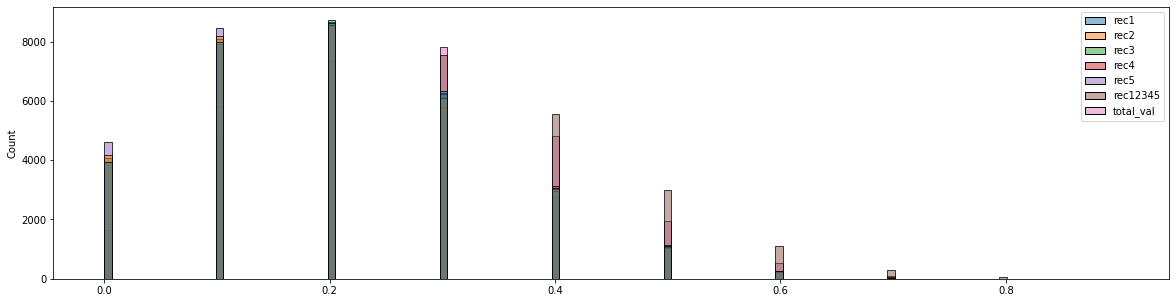

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (20, 5))
sns.histplot(data = new_df[["rec1", "rec2", "rec3", "rec4", "rec5", 'rec12345', 'total_val']])
plt.show()

In [23]:
new_df['total_name'].value_counts()

rec1    17836
rec2     4347
rec5     4094
rec3     3845
rec4     1238
Name: total_name, dtype: int64

In [24]:
new_df.mean()

user         15679.500000
len             18.487372
rec1             0.203839
rec2             0.200207
rec3             0.200236
rec4             0.204426
rec5             0.192140
rec12345         0.282586
total_val        0.254110
dtype: float64

In [25]:
candidate_cnt = 35

ndcg, hit = evaluate(
    model1 = model1, 
    model2 = model2, 
    model3 = model3, 
    model4 = model4, 
    RecVAE = model5, 
    X = X.todense(),
    user_train = user_train, 
    user_valid = user_valid, 
    candidate_cnt = candidate_cnt)

print(f'candidate_cnt: {candidate_cnt}| NDCG@10: {ndcg:.5f}| HIT@10: {hit:.5f}')

31360it [02:35, 201.37it/s]


candidate_cnt: 35| NDCG@10: 0.32099| HIT@10: 0.21087


In [33]:
for candidate_cnt in [5 * i for i in range(2, 21)]:
    
    ndcg, hit = evaluate(
        model1 = model1,
        model2 = model2,
        model3 = model3,
        model4 = model4,
        RecVAE = model5,
        X = X.todense(),
        user_train = user_train, 
        user_valid = user_valid, 
        candidate_cnt = candidate_cnt)

    print(f'candidate_cnt: {candidate_cnt}| NDCG@10: {ndcg:.5f}| HIT@10: {hit:.5f}')

31360it [02:34, 203.33it/s]


candidate_cnt: 10| NDCG@10: 0.31945| HIT@10: 0.20952


31360it [02:34, 202.62it/s]


candidate_cnt: 15| NDCG@10: 0.31997| HIT@10: 0.21003


31360it [02:38, 198.20it/s]


candidate_cnt: 20| NDCG@10: 0.32015| HIT@10: 0.21019


31360it [02:35, 202.19it/s]


candidate_cnt: 25| NDCG@10: 0.32026| HIT@10: 0.21032


31360it [02:37, 199.35it/s]


candidate_cnt: 30| NDCG@10: 0.32039| HIT@10: 0.21046


31360it [02:36, 200.17it/s]


candidate_cnt: 35| NDCG@10: 0.32034| HIT@10: 0.21040


31360it [02:37, 198.80it/s]


candidate_cnt: 40| NDCG@10: 0.32030| HIT@10: 0.21037


31360it [02:39, 196.13it/s]


candidate_cnt: 45| NDCG@10: 0.32035| HIT@10: 0.21041


31360it [02:40, 195.62it/s]


candidate_cnt: 50| NDCG@10: 0.32036| HIT@10: 0.21044


31360it [02:42, 193.25it/s]


candidate_cnt: 55| NDCG@10: 0.32036| HIT@10: 0.21043


31360it [02:46, 188.75it/s]


candidate_cnt: 60| NDCG@10: 0.32035| HIT@10: 0.21042


31360it [02:45, 188.97it/s]


candidate_cnt: 65| NDCG@10: 0.32035| HIT@10: 0.21042


31360it [02:53, 180.94it/s]


candidate_cnt: 70| NDCG@10: 0.32036| HIT@10: 0.21042


31360it [02:53, 181.18it/s]


candidate_cnt: 75| NDCG@10: 0.32034| HIT@10: 0.21039


31360it [02:52, 181.30it/s]


candidate_cnt: 80| NDCG@10: 0.32036| HIT@10: 0.21042


31360it [02:56, 178.11it/s]


candidate_cnt: 85| NDCG@10: 0.32037| HIT@10: 0.21044


31360it [02:58, 175.86it/s]


candidate_cnt: 90| NDCG@10: 0.32036| HIT@10: 0.21042


31360it [03:02, 172.23it/s]


candidate_cnt: 95| NDCG@10: 0.32036| HIT@10: 0.21042


31360it [02:59, 174.35it/s]


candidate_cnt: 100| NDCG@10: 0.32037| HIT@10: 0.21043


In [25]:
for candidate_cnt in [5 * i for i in range(2, 21)]:
    
    ndcg, hit = evaluate(
        model1 = model1,
        model2 = model2,
        model3 = model3,
        model4 = model4,
        RecVAE = model5,
        X = X.todense(),
        user_train = user_train, 
        user_valid = user_valid, 
        candidate_cnt = candidate_cnt)

    print(f'candidate_cnt: {candidate_cnt}| NDCG@10: {ndcg:.5f}| HIT@10: {hit:.5f}')

31360it [02:33, 204.31it/s]


candidate_cnt: 10| NDCG@10: 0.31989| HIT@10: 0.20949


31360it [02:33, 203.98it/s]


candidate_cnt: 15| NDCG@10: 0.32088| HIT@10: 0.21066


31360it [02:34, 203.10it/s]


candidate_cnt: 20| NDCG@10: 0.32105| HIT@10: 0.21084


31360it [02:35, 202.13it/s]


candidate_cnt: 25| NDCG@10: 0.32116| HIT@10: 0.21093


31360it [02:36, 200.14it/s]


candidate_cnt: 30| NDCG@10: 0.32117| HIT@10: 0.21099


31360it [02:36, 199.89it/s]


candidate_cnt: 35| NDCG@10: 0.32121| HIT@10: 0.21105


31360it [02:37, 198.95it/s]


candidate_cnt: 40| NDCG@10: 0.32112| HIT@10: 0.21095


In [26]:
def get_weighted_ensemble_df(model1, model2, model3, model4, RecVAE, X, candidate_cnt):
    weighted_ensemble_df = {}
    
    RecVAE.eval()

    mat = torch.from_numpy(X)

    recon_mat1 = model1.pred.cpu()
    recon_mat1[mat == 1] = -np.inf
    rec_list1 = recon_mat1.argsort(dim = 1)

    recon_mat2 = model2.pred.T.cpu()
    recon_mat2[mat == 1] = -np.inf
    rec_list2 = recon_mat2.argsort(dim = 1)

    recon_mat3 = model3.pred.cpu()
    recon_mat3[mat == 1] = -np.inf
    rec_list3 = recon_mat3.argsort(dim = 1)

    recon_mat4 = model4.pred.cpu()
    recon_mat4[mat == 1] = -np.inf
    rec_list4 = recon_mat4.argsort(dim = 1)

    recon_mat5 = RecVAE(mat.to(device), calculate_loss = False).cpu().detach()
    recon_mat5[mat == 1] = -np.inf
    rec_list5 = recon_mat5.argsort(dim = 1)

    score_li = np.array([1/np.log2(rank + 2) for rank in range(0, candidate_cnt)])

    for user, (rec1, rec2, rec3, rec4, rec5) in tqdm(enumerate(zip(rec_list1, rec_list2, rec_list3, rec_list4, rec_list5))):

        # ranking
        rec1 = rec1[-candidate_cnt:].cpu().numpy().tolist()[::-1]
        rec2 = rec2[-candidate_cnt:].cpu().numpy().tolist()[::-1]
        rec3 = rec3[-candidate_cnt:].cpu().numpy().tolist()[::-1]
        rec4 = rec4[-candidate_cnt:].cpu().numpy().tolist()[::-1]
        rec5 = rec5[-candidate_cnt:].cpu().numpy().tolist()[::-1]

        items = list(set(rec1 + rec2 + rec3 + rec4 + rec5))

        movie_df = pd.DataFrame(index = items)
        movie_df.loc[rec1, 'rec1_score'] = score_li
        movie_df.loc[rec2, 'rec2_score'] = score_li
        movie_df.loc[rec3, 'rec3_score'] = score_li
        movie_df.loc[rec4, 'rec4_score'] = score_li
        movie_df.loc[rec5, 'rec5_score'] = score_li

        weighted_ensemble_df[user] = movie_df

    return weighted_ensemble_df

In [27]:
weighted_ensemble_df = get_weighted_ensemble_df(
    model1 = model1, 
    model2 = model2, 
    model3 = model3, 
    model4 = model4, 
    RecVAE = model5, 
    X = X.todense(),
    candidate_cnt = 10,
    )

31360it [01:48, 289.47it/s]


In [31]:
target_cols = ['rec5_score']
weightes_list = [np.round(0.05 * i, 2) for i in range(20, 0, -1)]
cols = ['rec4_score', 'rec1_score', 'rec3_score', 'rec2_score']
weightes = [1.0, 0.8, 0.9, 1.0]
users = weighted_ensemble_df.keys()
for target_col in target_cols:
    cols += [target_col]
    best_hit = 0
    best_weightes = deepcopy(weightes)

    for target_weighte in tqdm(weightes_list):
        _weightes = deepcopy(weightes)
        _weightes += [target_weighte]

        NDCG = 0
        HIT = 0

        for user in users:
            uv = user_valid[user]
            df = weighted_ensemble_df[user].copy()

            for c, w in zip(cols, _weightes):
                df[c] = df[c] * w
            
            df = df.fillna(df[cols].min().min())
            df['total_score'] = df[cols].sum(axis = 1)
            df = df.sort_values('total_score', ascending = False)
            up = df.index.tolist()[:10]

            NDCG += get_ndcg(pred_list = up, true_list = uv)
            HIT += get_hit(pred_list = up, true_list = uv)

        NDCG /= len(users)
        HIT /= len(users)
        
        if best_hit < HIT:
            best_weightes = deepcopy(_weightes)
            best_hit = HIT
            best_ndcg = NDCG

        print(f'cols : {cols}| weighte : {_weightes}| NDCG@10: {NDCG:.5f}| HIT@10: {HIT:.5f}')

    weightes = deepcopy(best_weightes)
    print(f'BEST cols : {cols}| weighte : {weightes}| NDCG@10: {best_ndcg:.5f}| HIT@10: {best_hit:.5f} \n')

print(f'cols : {cols}| weighte : {weightes}')

  5%|▌         | 1/20 [02:09<40:56, 129.27s/it]

cols : ['rec4_score', 'rec1_score', 'rec3_score', 'rec2_score', 'rec5_score']| weighte : [1.0, 0.8, 0.9, 1.0, 1.0]| NDCG@10: 0.31945| HIT@10: 0.20952


 10%|█         | 2/20 [04:16<38:24, 128.00s/it]

cols : ['rec4_score', 'rec1_score', 'rec3_score', 'rec2_score', 'rec5_score']| weighte : [1.0, 0.8, 0.9, 1.0, 0.95]| NDCG@10: 0.31928| HIT@10: 0.20942


 15%|█▌        | 3/20 [06:24<36:15, 127.99s/it]

cols : ['rec4_score', 'rec1_score', 'rec3_score', 'rec2_score', 'rec5_score']| weighte : [1.0, 0.8, 0.9, 1.0, 0.9]| NDCG@10: 0.31908| HIT@10: 0.20929


 20%|██        | 4/20 [08:31<34:01, 127.59s/it]

cols : ['rec4_score', 'rec1_score', 'rec3_score', 'rec2_score', 'rec5_score']| weighte : [1.0, 0.8, 0.9, 1.0, 0.85]| NDCG@10: 0.31873| HIT@10: 0.20901


 25%|██▌       | 5/20 [10:38<31:52, 127.50s/it]

cols : ['rec4_score', 'rec1_score', 'rec3_score', 'rec2_score', 'rec5_score']| weighte : [1.0, 0.8, 0.9, 1.0, 0.8]| NDCG@10: 0.31839| HIT@10: 0.20870


 25%|██▌       | 5/20 [10:45<32:15, 129.05s/it]


KeyboardInterrupt: 

## 6. 예측

In [14]:
make_matrix_data_set = MakeMatrixDataSet(config = config)
X_test = make_matrix_data_set.make_sparse_matrix(test = True)

In [15]:
model1 = EASE(X = X_test, reg = 750)
model1.fit()

In [16]:
model2 = EASE(X = X_test.T, reg = 4400)
model2.fit()

In [17]:
model3 = AdmmSlim(lambda_2 = 1, rho = 1000)
model3.fit(X = X_test.toarray())

In [18]:
model4 = HOSLIM(threshold = 3500, lambdaBB = 500, lambdaCC = 10000, rho = 100000)
model4.fit(X = X_test.toarray())

In [19]:
model5 = RecVAE(
    input_dim = make_matrix_data_set.num_item,).to(device)

model5.load_state_dict(torch.load(os.path.join(config.model_path, 'RecVAE_v3.pt')))

<All keys matched successfully>

In [22]:
user2rec_list = predict(
    model1 = model1, 
    model2 = model2, 
    model3 = model3, 
    model4 = model4, 
    RecVAE = model5, 
    X = X_test.todense(),
    candidate_cnt = 35,)

submision = []
users = [i for i in range(0, make_matrix_data_set.num_user)]
for user in users:
    rec_item_list = user2rec_list[user]
    for item in rec_item_list:
        submision.append(
            {   
                'user' : make_matrix_data_set.user_decoder[user],
                'item' : make_matrix_data_set.item_decoder[item],
            }
        )

submision = pd.DataFrame(submision)

31360it [02:36, 200.20it/s]


In [23]:
submision.to_csv(os.path.join(config.submission_path, config.submission_name), index=False)

In [24]:
submision

,user,item
0,11,4370
1,11,40815
2,11,4886
3,11,8961
4,11,7373
...,...,...
313595,138493,27660
313596,138493,110
313597,138493,53125
313598,138493,8970


# 과거

In [ ]:
# def evaluate(model1, model2, RecVAE, AutoRec, MultiDAE, MultiVAE, X, user_train, user_valid, candidate_cnt):
#     RecVAE.eval()
#     AutoRec.eval()
#     MultiDAE.eval()
#     MultiVAE.eval()

#     mat = torch.from_numpy(X)

#     NDCG = 0.0 # NDCG@10
#     HIT = 0.0 # HIT@10

#     recon_mat1 = model1.pred.cpu()
#     recon_mat1[mat == 1] = -np.inf
#     rec_list1 = recon_mat1.argsort(dim = 1)

#     recon_mat2 = model2.pred.T.cpu()
#     recon_mat2[mat == 1] = -np.inf
#     rec_list2 = recon_mat2.argsort(dim = 1)

#     recon_mat3 = RecVAE(mat.to(device), calculate_loss = False).cpu().detach()
#     recon_mat3[mat == 1] = -np.inf
#     rec_list3 = recon_mat3.argsort(dim = 1)

#     recon_mat4 = AutoRec(mat.to(device)).cpu().detach()
#     recon_mat4[mat == 1] = -np.inf
#     rec_list4 = recon_mat4.argsort(dim = 1)

#     recon_mat5 = MultiDAE(mat.to(device)).cpu().detach()
#     recon_mat5[mat == 1] = -np.inf
#     rec_list5 = recon_mat5.argsort(dim = 1)

#     recon_mat6, mu, logvar = MultiVAE(mat.to(device))
#     recon_mat6 = recon_mat6.cpu().detach()
#     recon_mat6[mat == 1] = -np.inf
#     rec_list6 = recon_mat6.argsort(dim = 1)

#     score_li = np.array([1/np.log2(rank + 2) for rank in range(0, candidate_cnt)])

#     for user, (rec1, rec2, rec3, rec4, rec5, rec6) in tqdm(enumerate(zip(rec_list1, rec_list2, rec_list3, rec_list4, rec_list5, rec_list6))):
#         uv = user_valid[user]

#         # ranking
#         rec1 = rec1[-candidate_cnt:].cpu().numpy().tolist()[::-1]
#         rec2 = rec2[-candidate_cnt:].cpu().numpy().tolist()[::-1]
#         rec3 = rec3[-candidate_cnt:].cpu().numpy().tolist()[::-1]
#         rec4 = rec4[-candidate_cnt:].cpu().numpy().tolist()[::-1]
#         rec5 = rec5[-candidate_cnt:].cpu().numpy().tolist()[::-1]
#         rec6 = rec6[-candidate_cnt:].cpu().numpy().tolist()[::-1]

#         items = list(set(rec1 + rec2 + rec3 + rec4 + rec5 + rec6))

#         movie_df = pd.DataFrame(index = items)
#         movie_df.loc[rec1, 'rec1_score'] = score_li * 1.0
#         movie_df.loc[rec2, 'rec2_score'] = score_li * 0.4
#         movie_df.loc[rec3, 'rec3_score'] = score_li * 0.6
#         movie_df.loc[rec4, 'rec4_score'] = score_li * 0.1
#         movie_df.loc[rec5, 'rec5_score'] = score_li * 0.3
#         movie_df.loc[rec6, 'rec6_score'] = score_li * 0.2
#         movie_df = movie_df.fillna(min(score_li) * 0.1)
#         movie_df['total_score'] = movie_df['rec1_score'] + movie_df['rec2_score'] + movie_df['rec3_score'] + movie_df['rec4_score'] + movie_df['rec5_score'] + movie_df['rec6_score']
#         movie_df = movie_df.sort_values('total_score', ascending = False)
#         up = movie_df.index.tolist()[:10]

#         NDCG += get_ndcg(pred_list = up, true_list = uv)
#         HIT += get_hit(pred_list = up, true_list = uv)

#     NDCG /= len(user_train)
#     HIT /= len(user_train)

#     return NDCG, HIT

# def predict(model1, model2, RecVAE, AutoRec, MultiDAE, MultiVAE, X, candidate_cnt):
#     user2rec = {}

#     RecVAE.eval()
#     AutoRec.eval()
#     MultiDAE.eval()
#     MultiVAE.eval()

#     mat = torch.from_numpy(X)

#     recon_mat1 = model1.pred.cpu()
#     recon_mat1[mat == 1] = -np.inf
#     rec_list1 = recon_mat1.argsort(dim = 1)

#     recon_mat2 = model2.pred.T.cpu()
#     recon_mat2[mat == 1] = -np.inf
#     rec_list2 = recon_mat2.argsort(dim = 1)

#     recon_mat3 = RecVAE(mat.to(device), calculate_loss = False).cpu().detach()
#     recon_mat3[mat == 1] = -np.inf
#     rec_list3 = recon_mat3.argsort(dim = 1)

#     recon_mat4 = AutoRec(mat.to(device)).cpu().detach()
#     recon_mat4[mat == 1] = -np.inf
#     rec_list4 = recon_mat4.argsort(dim = 1)

#     recon_mat5 = MultiDAE(mat.to(device)).cpu().detach()
#     recon_mat5[mat == 1] = -np.inf
#     rec_list5 = recon_mat5.argsort(dim = 1)

#     recon_mat6, mu, logvar = MultiVAE(mat.to(device))
#     recon_mat6 = recon_mat6.cpu().detach()
#     recon_mat6[mat == 1] = -np.inf
#     rec_list6 = recon_mat6.argsort(dim = 1)

#     score_li = np.array([1/np.log2(rank + 2) for rank in range(0, candidate_cnt)])

#     for user, (rec1, rec2, rec3, rec4, rec5, rec6) in tqdm(enumerate(zip(rec_list1, rec_list2, rec_list3, rec_list4, rec_list5, rec_list6))):
        
#         # ranking
#         rec1 = rec1[-candidate_cnt:].cpu().numpy().tolist()[::-1]
#         rec2 = rec2[-candidate_cnt:].cpu().numpy().tolist()[::-1]
#         rec3 = rec3[-candidate_cnt:].cpu().numpy().tolist()[::-1]
#         rec4 = rec4[-candidate_cnt:].cpu().numpy().tolist()[::-1]
#         rec5 = rec5[-candidate_cnt:].cpu().numpy().tolist()[::-1]
#         rec6 = rec6[-candidate_cnt:].cpu().numpy().tolist()[::-1]

#         items = list(set(rec1 + rec2 + rec3 + rec4 + rec5 + rec6))

#         movie_df = pd.DataFrame(index = items)
#         movie_df.loc[rec1, 'rec1_score'] = score_li * 1.0
#         movie_df.loc[rec2, 'rec2_score'] = score_li * 0.4
#         movie_df.loc[rec3, 'rec3_score'] = score_li * 0.6
#         movie_df.loc[rec4, 'rec4_score'] = score_li * 0.1
#         movie_df.loc[rec5, 'rec5_score'] = score_li * 0.3
#         movie_df.loc[rec6, 'rec6_score'] = score_li * 0.2
#         movie_df = movie_df.fillna(min(score_li) * 0.1)
#         movie_df['total_score'] = movie_df['rec1_score'] + movie_df['rec2_score'] + movie_df['rec3_score'] + movie_df['rec4_score'] + movie_df['rec5_score'] + movie_df['rec6_score']
#         movie_df = movie_df.sort_values('total_score', ascending = False)
#         up = movie_df.index.tolist()[:10]

#         user2rec[user] = up

#     return user2rec


# def total_evaluate(model1, model2, RecVAE, AutoRec, MultiDAE, MultiVAE, X, user_train, user_valid, candidate_cnt):
#     RecVAE.eval()
#     AutoRec.eval()
#     MultiDAE.eval()
#     MultiVAE.eval()

#     df = []

#     mat = torch.from_numpy(X)

#     recon_mat1 = model1.pred.cpu()
#     recon_mat1[mat == 1] = -np.inf
#     rec_list1 = recon_mat1.argsort(dim = 1)

#     recon_mat2 = model2.pred.T.cpu()
#     recon_mat2[mat == 1] = -np.inf
#     rec_list2 = recon_mat2.argsort(dim = 1)

#     recon_mat3 = RecVAE(mat.to(device), calculate_loss = False).cpu().detach()
#     recon_mat3[mat == 1] = -np.inf
#     rec_list3 = recon_mat3.argsort(dim = 1)

#     recon_mat4 = AutoRec(mat.to(device)).cpu().detach()
#     recon_mat4[mat == 1] = -np.inf
#     rec_list4 = recon_mat4.argsort(dim = 1)

#     recon_mat5 = MultiDAE(mat.to(device)).cpu().detach()
#     recon_mat5[mat == 1] = -np.inf
#     rec_list5 = recon_mat5.argsort(dim = 1)

#     recon_mat6, mu, logvar = MultiVAE(mat.to(device))
#     recon_mat6 = recon_mat6.cpu().detach()
#     recon_mat6[mat == 1] = -np.inf
#     rec_list6 = recon_mat6.argsort(dim = 1)

#     for user, (rec1, rec2, rec3, rec4, rec5, rec6) in tqdm(enumerate(zip(rec_list1, rec_list2, rec_list3, rec_list4, rec_list5, rec_list6))):
#         uv = user_valid[user]

#         # ranking
#         rec1 = rec1[-candidate_cnt:].cpu().numpy().tolist()[::-1]
#         rec2 = rec2[-candidate_cnt:].cpu().numpy().tolist()[::-1]
#         rec3 = rec3[-candidate_cnt:].cpu().numpy().tolist()[::-1]
#         rec4 = rec4[-candidate_cnt:].cpu().numpy().tolist()[::-1]
#         rec5 = rec5[-candidate_cnt:].cpu().numpy().tolist()[::-1]
#         rec6 = rec6[-candidate_cnt:].cpu().numpy().tolist()[::-1]

#         rec123456 = list(set(rec1 + rec2 + rec3 + rec4 + rec5 + rec6))

#         df.append(
#             {
#                'user' : user,
#                'len' : len(rec123456),

#                'rec1' : get_hit(pred_list = rec1, true_list = uv),
#                'rec2' : get_hit(pred_list = rec2, true_list = uv),
#                'rec3' : get_hit(pred_list = rec3, true_list = uv),
#                'rec4' : get_hit(pred_list = rec4, true_list = uv),
#                'rec5' : get_hit(pred_list = rec5, true_list = uv),
#                'rec6' : get_hit(pred_list = rec6, true_list = uv),

#                'rec123456' : get_hit(pred_list = rec123456, true_list = uv),
#             }
#         )

#     return df

In [ ]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.tree import DecisionTreeClassifier

# def evaluate(model1, model2, RecVAE, AutoRec, MultiDAE, MultiVAE, X_df, y_df, X, user_train, user_valid, candidate_cnt):
#     RecVAE.eval()
#     AutoRec.eval()
#     MultiDAE.eval()
#     MultiVAE.eval()

#     mat = torch.from_numpy(X)

#     NDCG = 0.0 # NDCG@10
#     HIT = 0.0 # HIT@10

#     recon_mat1 = model1.pred.cpu()
#     copy_recon_mat1 = deepcopy(recon_mat1.sigmoid())
#     recon_mat1[mat == 1] = -np.inf
#     rec_list1 = recon_mat1.argsort(dim = 1)

#     recon_mat2 = model2.pred.T.cpu()
#     copy_recon_mat2 = deepcopy(recon_mat2.sigmoid())
#     recon_mat2[mat == 1] = -np.inf
#     rec_list2 = recon_mat2.argsort(dim = 1)

#     recon_mat3 = RecVAE(mat.to(device), calculate_loss = False).cpu().detach()
#     copy_recon_mat3 = deepcopy(recon_mat3.sigmoid())
#     recon_mat3[mat == 1] = -np.inf
#     rec_list3 = recon_mat3.argsort(dim = 1)

#     recon_mat4 = AutoRec(mat.to(device)).cpu().detach()
#     copy_recon_mat4 = deepcopy(recon_mat4.sigmoid())
#     recon_mat4[mat == 1] = -np.inf
#     rec_list4 = recon_mat4.argsort(dim = 1)

#     recon_mat5 = MultiDAE(mat.to(device)).cpu().detach()
#     copy_recon_mat5 = deepcopy(recon_mat5.sigmoid())
#     recon_mat5[mat == 1] = -np.inf
#     rec_list5 = recon_mat5.argsort(dim = 1)

#     recon_mat6, mu, logvar = MultiVAE(mat.to(device))
#     recon_mat6 = recon_mat6.cpu().detach()
#     copy_recon_mat6 = deepcopy(recon_mat6.sigmoid())
#     recon_mat6[mat == 1] = -np.inf
#     rec_list6 = recon_mat6.argsort(dim = 1)


#     for user, (rec1, rec2, rec3, rec4, rec5, rec6) in tqdm(enumerate(zip(rec_list1, rec_list2, rec_list3, rec_list4, rec_list5, rec_list6))):

#         cif = DecisionTreeClassifier(random_state = config.seed).fit(X_df[6807 * user : 6807 * (user + 1), 1:], y_df[6807 * user : 6807 * (user + 1)])

#         uv = user_valid[user]

#         rec1 = rec1[-candidate_cnt:].cpu().numpy().tolist()[::-1]
#         rec2 = rec2[-candidate_cnt:].cpu().numpy().tolist()[::-1]
#         rec3 = rec3[-candidate_cnt:].cpu().numpy().tolist()[::-1]
#         rec4 = rec4[-candidate_cnt:].cpu().numpy().tolist()[::-1]
#         rec5 = rec5[-candidate_cnt:].cpu().numpy().tolist()[::-1]
#         rec6 = rec6[-candidate_cnt:].cpu().numpy().tolist()[::-1]

#         items = list(set(rec1 + rec2 + rec3 + rec4 + rec5 + rec6))
#         score_li = np.array([[copy_recon_mat1.numpy()[user][item], copy_recon_mat2.numpy()[user][item], copy_recon_mat3.numpy()[user][item] , copy_recon_mat4.numpy()[user][item] , copy_recon_mat5.numpy()[user][item] , copy_recon_mat6.numpy()[user][item]] for item in items])
#         score_li = cif.predict_proba(score_li)[:, 1]
        
#         movie_df = pd.DataFrame(index = items)
#         movie_df.loc[items, 'total_score'] = score_li
#         movie_df = movie_df.sort_values('total_score', ascending = False)
#         up = movie_df.index.tolist()[:10]

#         NDCG += get_ndcg(pred_list = up, true_list = uv)
#         HIT += get_hit(pred_list = up, true_list = uv)

#     NDCG /= len(user_train)
#     HIT /= len(user_train)

#     return NDCG, HIT


# def predict(model1, model2, RecVAE, X_df, y_df, X, candidate_cnt):
#     RecVAE.eval()

#     user2rec = {}

#     neg = torch.from_numpy(1 - X)
#     pos = torch.from_numpy(X)

#     recon_mat1 = model1.pred.cpu()
#     score1 = recon_mat1 * neg
#     rec_list1 = score1.argsort(dim = 1)

#     recon_mat2 = model2.pred.T.cpu()
#     score2 = recon_mat2 * neg
#     rec_list2 = score2.argsort(dim = 1)

#     recon_mat3 = RecVAE(pos.to(device), calculate_loss = False).cpu().detach()
#     score3 = recon_mat3 * neg
#     rec_list3 = score3.argsort(dim = 1)

#     for user, (rec1, rec2, rec3) in tqdm(enumerate(zip(rec_list1, rec_list2, rec_list3))):

#         cif = LogisticRegression(random_state = config.seed).fit(X_df[6807 * user : 6807 * (user + 1), 1:], y_df[6807 * user : 6807 * (user + 1)])

#         rec1 = rec1[-candidate_cnt:].cpu().numpy().tolist()[::-1]
#         rec2 = rec2[-candidate_cnt:].cpu().numpy().tolist()[::-1]
#         rec3 = rec3[-candidate_cnt:].cpu().numpy().tolist()[::-1]

#         items = list(set(rec1 + rec2 + rec3))
#         score_li = np.array([[recon_mat1.numpy()[user][item], recon_mat2.numpy()[user][item], recon_mat3.numpy()[user][item]] for item in items])
#         score_li = cif.predict_proba(score_li)[:, 1]
        
#         movie_df = pd.DataFrame(index = items)
#         movie_df.loc[items, 'total_score'] = score_li
#         movie_df = movie_df.sort_values('total_score', ascending = False)
#         up = movie_df.index.tolist()[:10]
        
#         user2rec[user] = up

#     return user2rec

In [ ]:
make_matrix_data_set = MakeMatrixDataSet(config = config)
user_train, user_valid = make_matrix_data_set.get_train_valid_data()
X = make_matrix_data_set.make_sparse_matrix()

In [ ]:
model1 = EASE(X = X, reg = 750)
model1.fit()

In [ ]:
model2 = EASE(X = X.T, reg = 4400)
model2.fit()

In [ ]:
model3 = RecVAE(
    input_dim = make_matrix_data_set.num_item,).to(device)

model3.load_state_dict(torch.load(os.path.join(config.model_path, 'RecVAE_v3.pt')))

<All keys matched successfully>

In [18]:
model4 = AutoRec(
    num = make_matrix_data_set.num_item, 
    num_factor = 64).to(device)

model4.load_state_dict(torch.load(os.path.join(config.model_path, 'AutoRec_v1.pt')))

<All keys matched successfully>

In [19]:
model5 = MultiDAE(
    p_dims = [100, 200, 400] + [make_matrix_data_set.num_item], 
    dropout_rate = 0.5).to(device)

model5.load_state_dict(torch.load(os.path.join(config.model_path, 'Multi-DAE_v1.pt')))

<All keys matched successfully>

In [20]:
model6 = MultiVAE(
    p_dims = [100, 200, 400] + [make_matrix_data_set.num_item], 
    dropout_rate = 0.5).to(device)

model6.load_state_dict(torch.load(os.path.join(config.model_path, 'Multi-VAE_v1.pt')))

<All keys matched successfully>

In [19]:
def get_weighted_ensemble_df(model1, model2, RecVAE, AutoRec, MultiDAE, MultiVAE, X, candidate_cnt):
    weighted_ensemble_df = {}
    
    RecVAE.eval()
    AutoRec.eval()
    MultiDAE.eval()
    MultiVAE.eval()

    mat = torch.from_numpy(X)

    recon_mat1 = model1.pred.cpu()
    recon_mat1[mat == 1] = -np.inf
    rec_list1 = recon_mat1.argsort(dim = 1)

    recon_mat2 = model2.pred.T.cpu()
    recon_mat2[mat == 1] = -np.inf
    rec_list2 = recon_mat2.argsort(dim = 1)

    recon_mat3 = RecVAE(mat.to(device), calculate_loss = False).cpu().detach()
    recon_mat3[mat == 1] = -np.inf
    rec_list3 = recon_mat3.argsort(dim = 1)

    recon_mat4 = AutoRec(mat.to(device)).cpu().detach()
    recon_mat4[mat == 1] = -np.inf
    rec_list4 = recon_mat4.argsort(dim = 1)

    recon_mat5 = MultiDAE(mat.to(device)).cpu().detach()
    recon_mat5[mat == 1] = -np.inf
    rec_list5 = recon_mat5.argsort(dim = 1)

    recon_mat6, mu, logvar = MultiVAE(mat.to(device))
    recon_mat6 = recon_mat6.cpu().detach()
    recon_mat6[mat == 1] = -np.inf
    rec_list6 = recon_mat6.argsort(dim = 1)

    score_li = np.array([1/np.log2(rank + 2) for rank in range(0, candidate_cnt)])

    for user, (rec1, rec2, rec3, rec4, rec5, rec6) in tqdm(enumerate(zip(rec_list1, rec_list2, rec_list3, rec_list4, rec_list5, rec_list6))):

        # ranking
        rec1 = rec1[-candidate_cnt:].cpu().numpy().tolist()[::-1]
        rec2 = rec2[-candidate_cnt:].cpu().numpy().tolist()[::-1]
        rec3 = rec3[-candidate_cnt:].cpu().numpy().tolist()[::-1]
        rec4 = rec4[-candidate_cnt:].cpu().numpy().tolist()[::-1]
        rec5 = rec5[-candidate_cnt:].cpu().numpy().tolist()[::-1]
        rec6 = rec6[-candidate_cnt:].cpu().numpy().tolist()[::-1]

        items = list(set(rec1 + rec2 + rec3 + rec4 + rec5 + rec6))

        movie_df = pd.DataFrame(index = items)
        movie_df.loc[rec1, 'rec1_score'] = score_li
        movie_df.loc[rec2, 'rec2_score'] = score_li
        movie_df.loc[rec3, 'rec3_score'] = score_li
        movie_df.loc[rec4, 'rec4_score'] = score_li
        movie_df.loc[rec5, 'rec5_score'] = score_li
        movie_df.loc[rec6, 'rec6_score'] = score_li

        weighted_ensemble_df[user] = movie_df

    return weighted_ensemble_df

In [20]:
weighted_ensemble_df = get_weighted_ensemble_df(
    model1 = model1,
    model2 = model2,
    RecVAE = model3,
    AutoRec = model4,
    MultiDAE = model5,
    MultiVAE = model6,
    X = X.todense(),
    candidate_cnt = 30,
    )

31360it [02:11, 237.93it/s]


In [ ]:
target_cols = ['rec5_score']
weightes_list = [np.round(0.05 * i, 2) for i in range(6, 0, -1)]
cols = ['rec1_score', 'rec2_score', 'rec3_score', 'rec6_score']
weightes = [1.0, 0.45, 0.85, 0.25]
users = weighted_ensemble_df.keys()
for target_col in target_cols:
    cols += [target_col]
    best_hit = 0
    best_weightes = deepcopy(weightes)

    for target_weighte in tqdm(weightes_list):
        _weightes = deepcopy(weightes)
        _weightes += [target_weighte]

        NDCG = 0
        HIT = 0

        for user in users:
            uv = user_valid[user]
            df = weighted_ensemble_df[user].copy()

            for c, w in zip(cols, _weightes):
                df[c] = df[c] * w
            
            df = df.fillna(df[cols].min().min())
            df['total_score'] = df[cols].sum(axis = 1)
            df = df.sort_values('total_score', ascending = False)
            up = df.index.tolist()[:10]

            NDCG += get_ndcg(pred_list = up, true_list = uv)
            HIT += get_hit(pred_list = up, true_list = uv)

        NDCG /= len(users)
        HIT /= len(users)
        
        if best_hit < HIT:
            best_weightes = deepcopy(_weightes)
            best_hit = HIT
            best_ndcg = NDCG

        print(f'cols : {cols}| weighte : {_weightes}| NDCG@10: {NDCG:.5f}| HIT@10: {HIT:.5f}')

    weightes = deepcopy(best_weightes)
    print(f'BEST cols : {cols}| weighte : {weightes}| NDCG@10: {best_ndcg:.5f}| HIT@10: {best_hit:.5f} \n')

print(f'cols : {cols}| weighte : {weightes}')

```
cols : ['rec1_score', 'rec2_score']| weighte : [1.0, 1.0]| NDCG@10: 0.31060| HIT@10: 0.20423
cols : ['rec1_score', 'rec2_score']| weighte : [1.0, 0.95]| NDCG@10: 0.31082| HIT@10: 0.20423
cols : ['rec1_score', 'rec2_score']| weighte : [1.0, 0.9]| NDCG@10: 0.31086| HIT@10: 0.20416
cols : ['rec1_score', 'rec2_score']| weighte : [1.0, 0.85]| NDCG@10: 0.31099| HIT@10: 0.20427
cols : ['rec1_score', 'rec2_score']| weighte : [1.0, 0.8]| NDCG@10: 0.31102| HIT@10: 0.20427
cols : ['rec1_score', 'rec2_score']| weighte : [1.0, 0.75]| NDCG@10: 0.31105| HIT@10: 0.20429
cols : ['rec1_score', 'rec2_score']| weighte : [1.0, 0.7]| NDCG@10: 0.31112| HIT@10: 0.20438
cols : ['rec1_score', 'rec2_score']| weighte : [1.0, 0.65]| NDCG@10: 0.31119| HIT@10: 0.20445
cols : ['rec1_score', 'rec2_score']| weighte : [1.0, 0.6]| NDCG@10: 0.31103| HIT@10: 0.20430
cols : ['rec1_score', 'rec2_score']| weighte : [1.0, 0.55]| NDCG@10: 0.31109| HIT@10: 0.20425
cols : ['rec1_score', 'rec2_score']| weighte : [1.0, 0.5]| NDCG@10: 0.31124| HIT@10: 0.20434
cols : ['rec1_score', 'rec2_score']| weighte : [1.0, 0.45]| NDCG@10: 0.31135| HIT@10: 0.20441
cols : ['rec1_score', 'rec2_score']| weighte : [1.0, 0.4]| NDCG@10: 0.31130| HIT@10: 0.20438
cols : ['rec1_score', 'rec2_score']| weighte : [1.0, 0.35]| NDCG@10: 0.31131| HIT@10: 0.20437
cols : ['rec1_score', 'rec2_score']| weighte : [1.0, 0.3]| NDCG@10: 0.31121| HIT@10: 0.20433
cols : ['rec1_score', 'rec2_score']| weighte : [1.0, 0.25]| NDCG@10: 0.31123| HIT@10: 0.20437
cols : ['rec1_score', 'rec2_score']| weighte : [1.0, 0.2]| NDCG@10: 0.31117| HIT@10: 0.20435
cols : ['rec1_score', 'rec2_score']| weighte : [1.0, 0.15]| NDCG@10: 0.31094| HIT@10: 0.20416
cols : ['rec1_score', 'rec2_score']| weighte : [1.0, 0.1]| NDCG@10: 0.31076| HIT@10: 0.20401
cols : ['rec1_score', 'rec2_score']| weighte : [1.0, 0.05]| NDCG@10: 0.31059| HIT@10: 0.20387
BEST cols : ['rec1_score', 'rec2_score']| weighte : [1.0, 0.65]| NDCG@10: 0.31119| HIT@10: 0.20445
BEST cols : ['rec1_score', 'rec2_score']| weighte : [1.0, 0.45]| NDCG@10: 0.31135| HIT@10: 0.20441


cols : ['rec1_score', 'rec2_score', 'rec3_score']| weighte : [1.0, 0.45, 1.0]| NDCG@10: 0.31727| HIT@10: 0.20922
cols : ['rec1_score', 'rec2_score', 'rec3_score']| weighte : [1.0, 0.45, 0.95]| NDCG@10: 0.31758| HIT@10: 0.20937
cols : ['rec1_score', 'rec2_score', 'rec3_score']| weighte : [1.0, 0.45, 0.9]| NDCG@10: 0.31786| HIT@10: 0.20948
cols : ['rec1_score', 'rec2_score', 'rec3_score']| weighte : [1.0, 0.45, 0.85]| NDCG@10: 0.31807| HIT@10: 0.20968
cols : ['rec1_score', 'rec2_score', 'rec3_score']| weighte : [1.0, 0.45, 0.8]| NDCG@10: 0.31808| HIT@10: 0.20967
cols : ['rec1_score', 'rec2_score', 'rec3_score']| weighte : [1.0, 0.45, 0.75]| NDCG@10: 0.31800| HIT@10: 0.20960
cols : ['rec1_score', 'rec2_score', 'rec3_score']| weighte : [1.0, 0.45, 0.7]| NDCG@10: 0.31790| HIT@10: 0.20943

cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec6_score']| weighte : [1.0, 0.45, 0.85, 1.0]| NDCG@10: 0.31444| HIT@10: 0.20739
cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec6_score']| weighte : [1.0, 0.45, 0.85, 0.95]| NDCG@10: 0.31503| HIT@10: 0.20768
cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec6_score']| weighte : [1.0, 0.45, 0.85, 0.9]| NDCG@10: 0.31536| HIT@10: 0.20784
cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec6_score']| weighte : [1.0, 0.45, 0.85, 0.85]| NDCG@10: 0.31568| HIT@10: 0.20799
cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec6_score']| weighte : [1.0, 0.45, 0.85, 0.8]| NDCG@10: 0.31625| HIT@10: 0.20818
cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec6_score']| weighte : [1.0, 0.45, 0.85, 0.75]| NDCG@10: 0.31661| HIT@10: 0.20837
cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec6_score']| weighte : [1.0, 0.45, 0.85, 0.7]| NDCG@10: 0.31705| HIT@10: 0.20858
cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec6_score']| weighte : [1.0, 0.45, 0.85, 0.65]| NDCG@10: 0.31733| HIT@10: 0.20866
cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec6_score']| weighte : [1.0, 0.45, 0.85, 0.6]| NDCG@10: 0.31769| HIT@10: 0.20884
cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec6_score']| weighte : [1.0, 0.45, 0.85, 0.55]| NDCG@10: 0.31801| HIT@10: 0.20918
cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec6_score']| weighte : [1.0, 0.45, 0.85, 0.5]| NDCG@10: 0.31837| HIT@10: 0.20943
cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec6_score']| weighte : [1.0, 0.45, 0.85, 0.45]| NDCG@10: 0.31860| HIT@10: 0.20962
cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec6_score']| weighte : [1.0, 0.45, 0.85, 0.4]| NDCG@10: 0.31874| HIT@10: 0.20975
cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec6_score']| weighte : [1.0, 0.45, 0.85, 0.35]| NDCG@10: 0.31895| HIT@10: 0.20997
cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec6_score']| weighte : [1.0, 0.45, 0.85, 0.3]| NDCG@10: 0.31918| HIT@10: 0.21020
cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec6_score']| weighte : [1.0, 0.45, 0.85, 0.25]| NDCG@10: 0.31922| HIT@10: 0.21031
cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec6_score']| weighte : [1.0, 0.45, 0.85, 0.2]| NDCG@10: 0.31918| HIT@10: 0.21026
cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec6_score']| weighte : [1.0, 0.45, 0.85, 0.15]| NDCG@10: 0.31910| HIT@10: 0.21023
cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec6_score']| weighte : [1.0, 0.45, 0.85, 0.1]| NDCG@10: 0.31883| HIT@10: 0.21006
cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec6_score']| weighte : [1.0, 0.45, 0.85, 0.05]| NDCG@10: 0.31852| HIT@10: 0.20981
BEST cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec6_score']| weighte : [1.0, 0.45, 0.85, 0.25]| NDCG@10: 0.31922| HIT@10: 0.21031 

cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec6_score', 'rec4_score']| weighte : [1.0, 0.45, 0.85, 0.25, 1.0]| NDCG@10: 0.31214| HIT@10: 0.20505
cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec6_score', 'rec4_score']| weighte : [1.0, 0.45, 0.85, 0.25, 0.95]| NDCG@10: 0.31263| HIT@10: 0.20535
cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec6_score', 'rec4_score']| weighte : [1.0, 0.45, 0.85, 0.25, 0.9]| NDCG@10: 0.31307| HIT@10: 0.20561
cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec6_score', 'rec4_score']| weighte : [1.0, 0.45, 0.85, 0.25, 0.85]| NDCG@10: 0.31359| HIT@10: 0.20593
cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec6_score', 'rec4_score']| weighte : [1.0, 0.45, 0.85, 0.25, 0.8]| NDCG@10: 0.31416| HIT@10: 0.20633
cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec6_score', 'rec4_score']| weighte : [1.0, 0.45, 0.85, 0.25, 0.75]| NDCG@10: 0.31459| HIT@10: 0.20653
cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec6_score', 'rec4_score']| weighte : [1.0, 0.45, 0.85, 0.25, 0.7]| NDCG@10: 0.31515| HIT@10: 0.20689
cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec6_score', 'rec4_score']| weighte : [1.0, 0.45, 0.85, 0.25, 0.65]| NDCG@10: 0.31555| HIT@10: 0.20718
cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec6_score', 'rec4_score']| weighte : [1.0, 0.45, 0.85, 0.25, 0.6]| NDCG@10: 0.31596| HIT@10: 0.20744
cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec6_score', 'rec4_score']| weighte : [1.0, 0.45, 0.85, 0.25, 0.55]| NDCG@10: 0.31644| HIT@10: 0.20779
cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec6_score', 'rec4_score']| weighte : [1.0, 0.45, 0.85, 0.25, 0.5]| NDCG@10: 0.31685| HIT@10: 0.20804
cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec6_score', 'rec4_score']| weighte : [1.0, 0.45, 0.85, 0.25, 0.45]| NDCG@10: 0.31724| HIT@10: 0.20838
cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec6_score', 'rec4_score']| weighte : [1.0, 0.45, 0.85, 0.25, 0.4]| NDCG@10: 0.31755| HIT@10: 0.20857
cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec6_score', 'rec4_score']| weighte : [1.0, 0.45, 0.85, 0.25, 0.35]| NDCG@10: 0.31794| HIT@10: 0.20890
cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec6_score', 'rec4_score']| weighte : [1.0, 0.45, 0.85, 0.25, 0.3]| NDCG@10: 0.31841| HIT@10: 0.20929
cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec6_score', 'rec4_score']| weighte : [1.0, 0.45, 0.85, 0.25, 0.25]| NDCG@10: 0.31871| HIT@10: 0.20968
cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec6_score', 'rec4_score']| weighte : [1.0, 0.45, 0.85, 0.25, 0.2]| NDCG@10: 0.31887| HIT@10: 0.20982
cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec6_score', 'rec4_score']| weighte : [1.0, 0.45, 0.85, 0.25, 0.15]| NDCG@10: 0.31908| HIT@10: 0.20995
cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec6_score', 'rec4_score']| weighte : [1.0, 0.45, 0.85, 0.25, 0.1]| NDCG@10: 0.31922| HIT@10: 0.21012
cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec6_score', 'rec4_score']| weighte : [1.0, 0.45, 0.85, 0.25, 0.05]| NDCG@10: 0.31937| HIT@10: 0.21024
BEST cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec6_score', 'rec4_score']| weighte : [1.0, 0.45, 0.85, 0.25, 0.05]| NDCG@10: 0.31937| HIT@10: 0.21024 

cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec6_score', 'rec4_score', 'rec5_score']| weighte : [1.0, 0.45, 0.85, 0.25, 0.05, 1.0]| NDCG@10: 0.31592| HIT@10: 0.20776
cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec6_score', 'rec4_score', 'rec5_score']| weighte : [1.0, 0.45, 0.85, 0.25, 0.05, 0.95]| NDCG@10: 0.31633| HIT@10: 0.20791
cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec6_score', 'rec4_score', 'rec5_score']| weighte : [1.0, 0.45, 0.85, 0.25, 0.05, 0.9]| NDCG@10: 0.31676| HIT@10: 0.20817
cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec6_score', 'rec4_score', 'rec5_score']| weighte : [1.0, 0.45, 0.85, 0.25, 0.05, 0.85]| NDCG@10: 0.31703| HIT@10: 0.20831
cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec6_score', 'rec4_score', 'rec5_score']| weighte : [1.0, 0.45, 0.85, 0.25, 0.05, 0.8]| NDCG@10: 0.31741| HIT@10: 0.20852
cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec6_score', 'rec4_score', 'rec5_score']| weighte : [1.0, 0.45, 0.85, 0.25, 0.05, 0.75]| NDCG@10: 0.31757| HIT@10: 0.20862
cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec6_score', 'rec4_score', 'rec5_score']| weighte : [1.0, 0.45, 0.85, 0.25, 0.05, 0.7]| NDCG@10: 0.31794| HIT@10: 0.20886
cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec6_score', 'rec4_score', 'rec5_score']| weighte : [1.0, 0.45, 0.85, 0.25, 0.05, 0.65]| NDCG@10: 0.31836| HIT@10: 0.20919
cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec6_score', 'rec4_score', 'rec5_score']| weighte : [1.0, 0.45, 0.85, 0.25, 0.05, 0.6]| NDCG@10: 0.31866| HIT@10: 0.20938
cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec6_score', 'rec4_score', 'rec5_score']| weighte : [1.0, 0.45, 0.85, 0.25, 0.05, 0.55]| NDCG@10: 0.31895| HIT@10: 0.20964
cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec6_score', 'rec4_score', 'rec5_score']| weighte : [1.0, 0.45, 0.85, 0.25, 0.05, 0.5]| NDCG@10: 0.31923| HIT@10: 0.20987
cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec6_score', 'rec4_score', 'rec5_score']| weighte : [1.0, 0.45, 0.85, 0.25, 0.05, 0.45]| NDCG@10: 0.31925| HIT@10: 0.20986
cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec6_score', 'rec4_score', 'rec5_score']| weighte : [1.0, 0.45, 0.85, 0.25, 0.05, 0.4]| NDCG@10: 0.31953| HIT@10: 0.21014
cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec6_score', 'rec4_score', 'rec5_score']| weighte : [1.0, 0.45, 0.85, 0.25, 0.05, 0.35]| NDCG@10: 0.31970| HIT@10: 0.21031
cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec6_score', 'rec4_score', 'rec5_score']| weighte : [1.0, 0.45, 0.85, 0.25, 0.05, 0.3]| NDCG@10: 0.31977| HIT@10: 0.21032
cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec6_score', 'rec4_score', 'rec5_score']| weighte : [1.0, 0.45, 0.85, 0.25, 0.05, 0.25]| NDCG@10: 0.31984| HIT@10: 0.21032
cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec6_score', 'rec4_score', 'rec5_score']| weighte : [1.0, 0.45, 0.85, 0.25, 0.05, 0.2]| NDCG@10: 0.31984| HIT@10: 0.21028

```

```
cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec4_score', 'rec5_score', 'rec6_score']| weighte : [1.0, 0.4, 1.0, 0.1, 0.3, 0.2]| NDCG@10: 0.31908| HIT@10: 0.21014
cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec4_score', 'rec5_score', 'rec6_score']| weighte : [1.0, 0.4, 0.9, 0.1, 0.3, 0.2]| NDCG@10: 0.31957| HIT@10: 0.21027
cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec4_score', 'rec5_score', 'rec6_score']| weighte : [1.0, 0.4, 0.8, 0.1, 0.3, 0.2]| NDCG@10: 0.31995| HIT@10: 0.21040
cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec4_score', 'rec5_score', 'rec6_score']| weighte : [1.0, 0.4, 0.7, 0.1, 0.3, 0.2]| NDCG@10: 0.31992| HIT@10: 0.21022
cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec4_score', 'rec5_score', 'rec6_score']| weighte : [1.0, 0.4, 0.6, 0.1, 0.3, 0.2]| NDCG@10: 0.32010| HIT@10: 0.21036
cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec4_score', 'rec5_score', 'rec6_score']| weighte : [1.0, 0.4, 0.5, 0.1, 0.3, 0.2]| NDCG@10: 0.31996| HIT@10: 0.21033
cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec4_score', 'rec5_score', 'rec6_score']| weighte : [1.0, 0.4, 0.4, 0.1, 0.3, 0.2]| NDCG@10: 0.31992| HIT@10: 0.21044
cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec4_score', 'rec5_score', 'rec6_score']| weighte : [1.0, 0.4, 0.3, 0.1, 0.3, 0.2]| NDCG@10: 0.31947| HIT@10: 0.21024
cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec4_score', 'rec5_score', 'rec6_score']| weighte : [1.0, 0.4, 0.2, 0.1, 0.3, 0.2]| NDCG@10: 0.31892| HIT@10: 0.20997
cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec4_score', 'rec5_score', 'rec6_score']| weighte : [1.0, 0.4, 0.1, 0.1, 0.3, 0.2]| NDCG@10: 0.31806| HIT@10: 0.20938
BEST cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec4_score', 'rec5_score', 'rec6_score']| weighte : [1.0, 0.4, 0.4, 0.1, 0.3, 0.2]| NDCG@10: 0.31992| HIT@10: 0.21044


cols : ['rec1_score', 'rec2_score']| weighte : [1.0, 1.0]| NDCG@10: 0.31060| HIT@10: 0.20423
cols : ['rec1_score', 'rec2_score']| weighte : [1.0, 0.9]| NDCG@10: 0.31086| HIT@10: 0.20416
cols : ['rec1_score', 'rec2_score']| weighte : [1.0, 0.8]| NDCG@10: 0.31102| HIT@10: 0.20427
cols : ['rec1_score', 'rec2_score']| weighte : [1.0, 0.7]| NDCG@10: 0.31112| HIT@10: 0.20438
cols : ['rec1_score', 'rec2_score']| weighte : [1.0, 0.6]| NDCG@10: 0.31103| HIT@10: 0.20430
cols : ['rec1_score', 'rec2_score']| weighte : [1.0, 0.5]| NDCG@10: 0.31124| HIT@10: 0.20434
cols : ['rec1_score', 'rec2_score']| weighte : [1.0, 0.4]| NDCG@10: 0.31130| HIT@10: 0.20438
cols : ['rec1_score', 'rec2_score']| weighte : [1.0, 0.3]| NDCG@10: 0.31121| HIT@10: 0.20433
cols : ['rec1_score', 'rec2_score']| weighte : [1.0, 0.2]| NDCG@10: 0.31117| HIT@10: 0.20435
cols : ['rec1_score', 'rec2_score']| weighte : [1.0, 0.1]| NDCG@10: 0.31076| HIT@10: 0.20401
BEST cols : ['rec1_score', 'rec2_score']| weighte : [1.0, 0.4]| NDCG@10: 0.31130| HIT@10: 0.20438


cols : ['rec1_score', 'rec2_score', 'rec3_score']| weighte : [1.0, 0.4, 1.0]| NDCG@10: 0.31716| HIT@10: 0.20921
cols : ['rec1_score', 'rec2_score', 'rec3_score']| weighte : [1.0, 0.4, 0.9]| NDCG@10: 0.31770| HIT@10: 0.20940
cols : ['rec1_score', 'rec2_score', 'rec3_score']| weighte : [1.0, 0.4, 0.8]| NDCG@10: 0.31789| HIT@10: 0.20956
cols : ['rec1_score', 'rec2_score', 'rec3_score']| weighte : [1.0, 0.4, 0.7]| NDCG@10: 0.31788| HIT@10: 0.20950
cols : ['rec1_score', 'rec2_score', 'rec3_score']| weighte : [1.0, 0.4, 0.6]| NDCG@10: 0.31790| HIT@10: 0.20939
cols : ['rec1_score', 'rec2_score', 'rec3_score']| weighte : [1.0, 0.4, 0.5]| NDCG@10: 0.31738| HIT@10: 0.20897
cols : ['rec1_score', 'rec2_score', 'rec3_score']| weighte : [1.0, 0.4, 0.4]| NDCG@10: 0.31655| HIT@10: 0.20827
cols : ['rec1_score', 'rec2_score', 'rec3_score']| weighte : [1.0, 0.4, 0.3]| NDCG@10: 0.31571| HIT@10: 0.20768
cols : ['rec1_score', 'rec2_score', 'rec3_score']| weighte : [1.0, 0.4, 0.2]| NDCG@10: 0.31464| HIT@10: 0.20701
cols : ['rec1_score', 'rec2_score', 'rec3_score']| weighte : [1.0, 0.4, 0.1]| NDCG@10: 0.31317| HIT@10: 0.20593
BEST cols : ['rec1_score', 'rec2_score', 'rec3_score']| weighte : [1.0, 0.4, 0.8]| NDCG@10: 0.31789| HIT@10: 0.20956


cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec4_score']| weighte : [1.0, 0.4, 0.8, 1.0]| NDCG@10: 0.31056| HIT@10: 0.20408
cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec4_score']| weighte : [1.0, 0.4, 0.8, 0.9]| NDCG@10: 0.31171| HIT@10: 0.20482
cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec4_score']| weighte : [1.0, 0.4, 0.8, 0.8]| NDCG@10: 0.31265| HIT@10: 0.20543
cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec4_score']| weighte : [1.0, 0.4, 0.8, 0.7]| NDCG@10: 0.31363| HIT@10: 0.20602
cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec4_score']| weighte : [1.0, 0.4, 0.8, 0.6]| NDCG@10: 0.31465| HIT@10: 0.20672
cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec4_score']| weighte : [1.0, 0.4, 0.8, 0.5]| NDCG@10: 0.31570| HIT@10: 0.20752
cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec4_score']| weighte : [1.0, 0.4, 0.8, 0.4]| NDCG@10: 0.31650| HIT@10: 0.20812
cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec4_score']| weighte : [1.0, 0.4, 0.8, 0.3]| NDCG@10: 0.31727| HIT@10: 0.20872
cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec4_score']| weighte : [1.0, 0.4, 0.8, 0.2]| NDCG@10: 0.31779| HIT@10: 0.20912
cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec4_score']| weighte : [1.0, 0.4, 0.8, 0.1]| NDCG@10: 0.31793| HIT@10: 0.20937
BEST cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec4_score']| weighte : [1.0, 0.4, 0.8, 0.1]| NDCG@10: 0.31793| HIT@10: 0.20937


cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec4_score', 'rec5_score']| weighte : [1.0, 0.4, 0.8, 0.1, 1.0]| NDCG@10: 0.31535| HIT@10: 0.20741
cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec4_score', 'rec5_score']| weighte : [1.0, 0.4, 0.8, 0.1, 0.9]| NDCG@10: 0.31616| HIT@10: 0.20772
cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec4_score', 'rec5_score']| weighte : [1.0, 0.4, 0.8, 0.1, 0.8]| NDCG@10: 0.31695| HIT@10: 0.20824
cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec4_score', 'rec5_score']| weighte : [1.0, 0.4, 0.8, 0.1, 0.7]| NDCG@10: 0.31779| HIT@10: 0.20880
cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec4_score', 'rec5_score']| weighte : [1.0, 0.4, 0.8, 0.1, 0.6]| NDCG@10: 0.31865| HIT@10: 0.20948
cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec4_score', 'rec5_score']| weighte : [1.0, 0.4, 0.8, 0.1, 0.5]| NDCG@10: 0.31901| HIT@10: 0.20959
cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec4_score', 'rec5_score']| weighte : [1.0, 0.4, 0.8, 0.1, 0.4]| NDCG@10: 0.31922| HIT@10: 0.20979
cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec4_score', 'rec5_score']| weighte : [1.0, 0.4, 0.8, 0.1, 0.3]| NDCG@10: 0.31934| HIT@10: 0.21005
cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec4_score', 'rec5_score']| weighte : [1.0, 0.4, 0.8, 0.1, 0.2]| NDCG@10: 0.31904| HIT@10: 0.20992
cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec4_score', 'rec5_score']| weighte : [1.0, 0.4, 0.8, 0.1, 0.1]| NDCG@10: 0.31868| HIT@10: 0.20984
BEST cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec4_score', 'rec5_score']| weighte : [1.0, 0.4, 0.8, 0.1, 0.3]| NDCG@10: 0.31934| HIT@10: 0.21005


cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec4_score', 'rec5_score', 'rec6_score']| weighte : [1.0, 0.4, 0.8, 0.1, 0.3, 1.0]| NDCG@10: 0.31550| HIT@10: 0.20783
cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec4_score', 'rec5_score', 'rec6_score']| weighte : [1.0, 0.4, 0.8, 0.1, 0.3, 0.9]| NDCG@10: 0.31628| HIT@10: 0.20822
cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec4_score', 'rec5_score', 'rec6_score']| weighte : [1.0, 0.4, 0.8, 0.1, 0.3, 0.8]| NDCG@10: 0.31712| HIT@10: 0.20865
cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec4_score', 'rec5_score', 'rec6_score']| weighte : [1.0, 0.4, 0.8, 0.1, 0.3, 0.7]| NDCG@10: 0.31775| HIT@10: 0.20901
cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec4_score', 'rec5_score', 'rec6_score']| weighte : [1.0, 0.4, 0.8, 0.1, 0.3, 0.6]| NDCG@10: 0.31852| HIT@10: 0.20945
cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec4_score', 'rec5_score', 'rec6_score']| weighte : [1.0, 0.4, 0.8, 0.1, 0.3, 0.5]| NDCG@10: 0.31896| HIT@10: 0.20970
cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec4_score', 'rec5_score', 'rec6_score']| weighte : [1.0, 0.4, 0.8, 0.1, 0.3, 0.4]| NDCG@10: 0.31941| HIT@10: 0.20996
cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec4_score', 'rec5_score', 'rec6_score']| weighte : [1.0, 0.4, 0.8, 0.1, 0.3, 0.3]| NDCG@10: 0.31973| HIT@10: 0.21019
cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec4_score', 'rec5_score', 'rec6_score']| weighte : [1.0, 0.4, 0.8, 0.1, 0.3, 0.2]| NDCG@10: 0.31995| HIT@10: 0.21040
cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec4_score', 'rec5_score', 'rec6_score']| weighte : [1.0, 0.4, 0.8, 0.1, 0.3, 0.1]| NDCG@10: 0.31965| HIT@10: 0.21022
BEST cols : ['rec1_score', 'rec2_score', 'rec3_score', 'rec4_score', 'rec5_score', 'rec6_score']| weighte : [1.0, 0.4, 0.8, 0.1, 0.3, 0.2]| NDCG@10: 0.31995| HIT@10: 0.21040

```

In [ ]:
df = total_evaluate(
    model1 = model1,
    model2 = model2,
    RecVAE = model3,
    AutoRec = model4,
    MultiDAE = model5,
    MultiVAE = model6,
    X = X.todense(),
    user_train = user_train,
    user_valid = user_valid,
    candidate_cnt = 10,
    )

In [50]:
# 유저들 마다 rec1 or rec2 or rec3 or ranking 등 맞는 방법에 따라사 추천을 해주는 것도 좋은 방법이 될 수 있음

new_df = pd.DataFrame(df)

def get_total_name(x):
    val_list = [x['rec1'], x['rec2'], x['rec3'], x['rec4'], x['rec5'] , x['rec6']]
    max_val = max(val_list)
    val_idx = val_list.index(max_val)
    if val_idx == 0 : return 'rec1'
    elif val_idx == 1 : return 'rec2'
    elif val_idx == 2 : return 'rec3'
    elif val_idx == 3 : return 'rec4'
    elif val_idx == 4 : return 'rec5'
    elif val_idx == 5 : return 'rec6'

new_df['total_val'] = new_df.apply(lambda x: max(x['rec1'], x['rec2'], x['rec3'], x['rec4'], x['rec5'] , x['rec6']), axis = 1)
new_df['total_name'] = new_df.apply(lambda x: get_total_name(x), axis = 1)
new_df

,user,len,rec1,rec2,rec3,rec4,rec5,rec6,rec123456,total_val,total_name
0,0,27,0.3,0.3,0.2,0.2,0.2,0.2,0.5,0.3,rec1
1,1,23,0.1,0.1,0.2,0.1,0.1,0.1,0.2,0.2,rec3
2,2,22,0.3,0.3,0.3,0.3,0.2,0.1,0.3,0.3,rec1
3,3,19,0.3,0.3,0.2,0.2,0.2,0.2,0.4,0.3,rec1
4,4,23,0.4,0.3,0.4,0.3,0.5,0.4,0.5,0.5,rec5
...,...,...,...,...,...,...,...,...,...,...,...
31355,31355,17,0.2,0.4,0.2,0.2,0.2,0.2,0.4,0.4,rec2
31356,31356,26,0.3,0.3,0.3,0.2,0.5,0.0,0.5,0.5,rec5
31357,31357,21,0.2,0.3,0.2,0.1,0.1,0.1,0.3,0.3,rec2
31358,31358,23,0.1,0.1,0.0,0.0,0.0,0.0,0.1,0.1,rec1


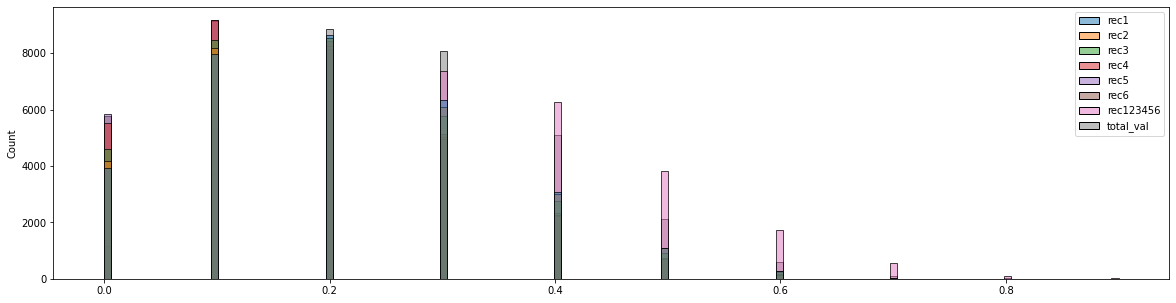

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (20, 5))
sns.histplot(data = new_df[["rec1", "rec2", "rec3", "rec4", "rec5", "rec6", 'rec123456', 'total_val']])
plt.show()

In [52]:
new_df['total_name'].value_counts()

rec1    16391
rec3     4737
rec2     3913
rec5     2433
rec4     2162
rec6     1724
Name: total_name, dtype: int64

In [53]:
new_df.mean()

user         15679.500000
len             24.823884
rec1             0.203839
rec2             0.200207
rec3             0.192140
rec4             0.174758
rec5             0.172388
rec6             0.174767
rec123456        0.313935
total_val        0.263115
dtype: float64

In [26]:
# users = np.concatenate([np.repeat(i, 6807) for i in range(31360)])

# model1_score = model1.pred.sigmoid().cpu().numpy().reshape(-1)

# model2_score = model2.pred.T.sigmoid().cpu().numpy().reshape(-1)

# model3_score = model3(torch.from_numpy(X.todense()).to(device), calculate_loss = False).sigmoid().cpu().detach().numpy().reshape(-1)

# model4_score = model4(torch.from_numpy(X.todense()).to(device)).sigmoid().cpu().detach().numpy().reshape(-1)

# model5_score = model5(torch.from_numpy(X.todense()).to(device)).sigmoid().cpu().detach().numpy().reshape(-1)

# model6_score, _, _ = model6(torch.from_numpy(X.todense()).to(device))
# model6_score = model6_score.sigmoid().cpu().detach().numpy().reshape(-1)

# X_df = np.concatenate([
#     users.reshape(-1, 1), 
#     model1_score.reshape(-1, 1), 
#     model2_score.reshape(-1, 1), 
#     model3_score.reshape(-1, 1), 
#     model4_score.reshape(-1, 1), 
#     model5_score.reshape(-1, 1),
#     model6_score.reshape(-1, 1)], axis = 1)

# y_df = X.toarray().reshape(-1)

In [13]:
# genre = pd.read_csv(os.path.join(config.data_path, 'genres.tsv'), sep='\t')
# genre['genres'] = 1
# genre['item_idx'] = genre['item'].apply(lambda x : make_matrix_data_set.item_encoder[x])
# genre = pd.pivot_table(genre, values='genres', index=['item_idx'], columns=['genre'], aggfunc=np.sum, fill_value=0).values

In [29]:
# candidate_cnt = 10

# ndcg, hit = evaluate(
#             model1 = model1, 
#             model2 = model2, 
#             RecVAE = model3,
#             AutoRec = model4,
#             MultiDAE = model5,
#             MultiVAE = model6,
#             X_df = X_df, 
#             y_df = y_df,
#             X = X.todense(),
#             user_train = user_train, 
#             user_valid = user_valid, 
#             candidate_cnt = candidate_cnt)

# print(f'candidate_cnt: {candidate_cnt}| NDCG@10: {ndcg:.5f}| HIT@10: {hit:.5f}')

31360it [16:22, 31.93it/s]

candidate_cnt: 10| NDCG@10: 0.17573| HIT@10: 0.13605


In [ ]:
# for candidate_cnt in [5 * i for i in range(3, 21)]:
#     ndcg, hit = evaluate(
#             model1 = model1, 
#             model2 = model2, 
#             RecVAE = model3,
#             X_df = X_df,
#             y_df = y_df,
#             X = X.todense(),
#             user_train = user_train, 
#             user_valid = user_valid, 
#             candidate_cnt = candidate_cnt)

#     print(f'candidate_cnt: {candidate_cnt}| NDCG@10: {ndcg:.5f}| HIT@10: {hit:.5f}')

In [21]:
candidate_cnt = 30

ndcg, hit = evaluate(
            model1 = model1, 
            model2 = model2, 
            RecVAE = model3,
            AutoRec = model4,
            MultiDAE = model5,
            MultiVAE = model6,
            X = X.todense(),
            user_train = user_train, 
            user_valid = user_valid, 
            candidate_cnt = candidate_cnt)

print(f'candidate_cnt: {candidate_cnt}| NDCG@10: {ndcg:.5f}| HIT@10: {hit:.5f}')

31360it [02:56, 177.77it/s]

candidate_cnt: 30| NDCG@10: 0.32010| HIT@10: 0.21036


```
NDCG@10: 0.32010| HIT@10: 0.21036
NDCG@10: 0.31992| HIT@10: 0.21044
```

In [ ]:
for candidate_cnt in [5 * i for i in range(2, 21)]:
    
    ndcg, hit = evaluate(
                model1 = model1,
                model2 = model2, 
                RecVAE = model3,
                AutoRec = model4,
                MultiDAE = model5,
                MultiVAE = model6,
                X = X.todense(),
                user_train = user_train, 
                user_valid = user_valid, 
                candidate_cnt = candidate_cnt)

    print(f'candidate_cnt: {candidate_cnt}| NDCG@10: {ndcg:.5f}| HIT@10: {hit:.5f}')

```
6개 모델+ log2(rank + 1) + weighted Ensemble [1.0, 0.4, 0.4, 0.1, 0.3, 0.2]

candidate_cnt: 10| NDCG@10: 0.31722| HIT@10: 0.20723
candidate_cnt: 15| NDCG@10: 0.31909| HIT@10: 0.20935
candidate_cnt: 20| NDCG@10: 0.31977| HIT@10: 0.21020
candidate_cnt: 25| NDCG@10: 0.31992| HIT@10: 0.21041
candidate_cnt: 30| NDCG@10: 0.31992| HIT@10: 0.21044
candidate_cnt: 35| NDCG@10: 0.31977| HIT@10: 0.21030

```

```
6개 모델+ log2(rank + 1) + weighted Ensemble (0.25, 0.25, 0.2, 0.1, 0.1, 0.1)
candidate_cnt: 10| NDCG@10: 0.31753| HIT@10: 0.20782
candidate_cnt: 15| NDCG@10: 0.31839| HIT@10: 0.20871
candidate_cnt: 20| NDCG@10: 0.31884| HIT@10: 0.20924
candidate_cnt: 25| NDCG@10: 0.31889| HIT@10: 0.20930
candidate_cnt: 30| NDCG@10: 0.31911| HIT@10: 0.20956
candidate_cnt: 35| NDCG@10: 0.31907| HIT@10: 0.20955
candidate_cnt: 40| NDCG@10: 0.31901| HIT@10: 0.20949
```

```
6개 모델 + voting
candidate_cnt: 10| NDCG@10: 0.29867| HIT@10: 0.20497
candidate_cnt: 15| NDCG@10: 0.28563| HIT@10: 0.20339
candidate_cnt: 20| NDCG@10: 0.27253| HIT@10: 0.19996
candidate_cnt: 25| NDCG@10: 0.25738| HIT@10: 0.19344
candidate_cnt: 30| NDCG@10: 0.24171| HIT@10: 0.18377
candidate_cnt: 35| NDCG@10: 0.22492| HIT@10: 0.17286
candidate_cnt: 40| NDCG@10: 0.20953| HIT@10: 0.16214
```

```
6개 모델 + log2(rank + 1)

candidate_cnt: 10| NDCG@10: 0.30926| HIT@10: 0.20194
candidate_cnt: 15| NDCG@10: 0.31167| HIT@10: 0.20401
candidate_cnt: 20| NDCG@10: 0.31282| HIT@10: 0.20501
candidate_cnt: 25| NDCG@10: 0.31330| HIT@10: 0.20542
candidate_cnt: 30| NDCG@10: 0.31366| HIT@10: 0.20572
candidate_cnt: 35| NDCG@10: 0.31382| HIT@10: 0.20584
candidate_cnt: 40| NDCG@10: 0.31397| HIT@10: 0.20594
candidate_cnt: 45| NDCG@10: 0.31408| HIT@10: 0.20603
candidate_cnt: 50| NDCG@10: 0.31416| HIT@10: 0.20611
candidate_cnt: 55| NDCG@10: 0.31422| HIT@10: 0.20613
candidate_cnt: 60| NDCG@10: 0.31427| HIT@10: 0.20618
candidate_cnt: 65| NDCG@10: 0.31430| HIT@10: 0.20620
candidate_cnt: 70| NDCG@10: 0.31435| HIT@10: 0.20623
candidate_cnt: 75| NDCG@10: 0.31435| HIT@10: 0.20624
candidate_cnt: 80| NDCG@10: 0.31438| HIT@10: 0.20627

```

```
EASE2개 + RecVAE-v3 + log2(rank + 1)
candidate_cnt: 10| NDCG@10: 0.31412| HIT@10: 0.20595
candidate_cnt: 15| NDCG@10: 0.31573| HIT@10: 0.20745
candidate_cnt: 20| NDCG@10: 0.31644| HIT@10: 0.20807
candidate_cnt: 25| NDCG@10: 0.31687| HIT@10: 0.20851
candidate_cnt: 30| NDCG@10: 0.31696| HIT@10: 0.20863
candidate_cnt: 35| NDCG@10: 0.31708| HIT@10: 0.20872
candidate_cnt: 40| NDCG@10: 0.31712| HIT@10: 0.20878
candidate_cnt: 45| NDCG@10: 0.31717| HIT@10: 0.20882
candidate_cnt: 50| NDCG@10: 0.31723| HIT@10: 0.20886
candidate_cnt: 55| NDCG@10: 0.31723| HIT@10: 0.20884
candidate_cnt: 60| NDCG@10: 0.31726| HIT@10: 0.20887
candidate_cnt: 65| NDCG@10: 0.31729| HIT@10: 0.20888
candidate_cnt: 70| NDCG@10: 0.31727| HIT@10: 0.20887
candidate_cnt: 75| NDCG@10: 0.31730| HIT@10: 0.20889
candidate_cnt: 80| NDCG@10: 0.31730| HIT@10: 0.20890
candidate_cnt: 85| NDCG@10: 0.31733| HIT@10: 0.20888

```

```
EASE2개 + RecVAE-v5 + log2(rank + 1)
candidate_cnt: 10| NDCG@10: 0.31372| HIT@10: 0.20602
candidate_cnt: 15| NDCG@10: 0.31518| HIT@10: 0.20735
candidate_cnt: 20| NDCG@10: 0.31569| HIT@10: 0.20779
candidate_cnt: 25| NDCG@10: 0.31605| HIT@10: 0.20812
candidate_cnt: 30| NDCG@10: 0.31616| HIT@10: 0.20822
candidate_cnt: 35| NDCG@10: 0.31627| HIT@10: 0.20833
candidate_cnt: 40| NDCG@10: 0.31636| HIT@10: 0.20843
candidate_cnt: 45| NDCG@10: 0.31643| HIT@10: 0.20846
candidate_cnt: 50| NDCG@10: 0.31644| HIT@10: 0.20848
candidate_cnt: 55| NDCG@10: 0.31653| HIT@10: 0.20854
candidate_cnt: 60| NDCG@10: 0.31657| HIT@10: 0.20857
candidate_cnt: 65| NDCG@10: 0.31652| HIT@10: 0.20856
candidate_cnt: 70| NDCG@10: 0.31653| HIT@10: 0.20856
candidate_cnt: 75| NDCG@10: 0.31651| HIT@10: 0.20855
candidate_cnt: 80| NDCG@10: 0.31658| HIT@10: 0.20858
candidate_cnt: 85| NDCG@10: 0.31660| HIT@10: 0.20859
candidate_cnt: 90| NDCG@10: 0.31658| HIT@10: 0.20860
candidate_cnt: 95| NDCG@10: 0.31662| HIT@10: 0.20862
candidate_cnt: 100| NDCG@10: 0.31658| HIT@10: 0.20861

```

```
candidate_cnt: 10| NDCG@10: 0.31372| HIT@10: 0.20602
```

```
none + logistic

candidate_cnt: 10| NDCG@10: 0.31411| HIT@10: 0.20686
```

```
sigmoid + logistic

candidate_cnt: 10| NDCG@10: 0.31568| HIT@10: 0.20702
```

```
softmax + logistic

candidate_cnt: 10| NDCG@10: 0.28598| HIT@10: 0.19227
```

```
none + sum

candidate_cnt: 10| NDCG@10: 0.31381| HIT@10: 0.20633
```

```
sigmoid + sum

candidate_cnt: 10| NDCG@10: 0.31469| HIT@10: 0.20636
```

[147, 197, 188, 313, 228, 273, 189, 114, 42, 242]

```
non softmax

score  genre_score  total_score
197   0.902873     0.411256     1.314129
42    0.815624     0.411256     1.226880
933   0.981398     0.172427     1.153824
718   0.671753     0.402721     1.074474
484   0.923667     0.149443     1.073110
376   0.883676     0.173539     1.057215
667   0.919388     0.097644     1.017032
650   0.855481     0.151946     1.007427
2200  0.878635     0.125442     1.004077
714   0.719053     0.210817     0.929870
1844  0.698690     0.226953     0.925643
273   0.810516     0.097710     0.908226
760   0.763495     0.036601     0.800096
313   0.766302     0.027069     0.793371
777   0.641927     0.142652     0.784579
228   0.733693     0.044058     0.777750
734   0.738835     0.031143     0.769978
1354  0.438386     0.122450     0.560836

```


```
softmax


score  genre_score  total_score
197   0.053804     0.411256     0.465060
42    0.053799     0.411256     0.465055
718   0.053844     0.402721     0.456565
1844  0.053790     0.226953     0.280743
714   0.053817     0.210817     0.264634
376   0.053824     0.173539     0.227363
933   0.053912     0.172427     0.226339
650   0.053820     0.151946     0.205766
484   0.053827     0.149443     0.203270
777   0.053828     0.142652     0.196481
2200  0.053810     0.125442     0.179252
1354  0.053825     0.122450     0.176275
273   0.053800     0.097710     0.151510
667   0.053807     0.097644     0.151450
228   0.053814     0.044058     0.097871
760   0.053811     0.036601     0.090412
734   0.053804     0.031143     0.084947
313   0.053817     0.027069     0.080885

```

## 6. 예측

In [22]:
make_matrix_data_set = MakeMatrixDataSet(config = config)
X_test = make_matrix_data_set.make_sparse_matrix(test = True)

In [23]:
model1 = EASE(X = X_test, reg = 750)
model1.fit()

In [24]:
model2 = EASE(X = X_test.T, reg = 4400)
model2.fit()

In [25]:
model3 = RecVAE(
    input_dim = make_matrix_data_set.num_item,).to(device)

model3.load_state_dict(torch.load(os.path.join(config.model_path, 'RecVAE_v3.pt')))

<All keys matched successfully>

In [26]:
model4 = AutoRec(
    num = make_matrix_data_set.num_item, 
    num_factor = 64).to(device)

model4.load_state_dict(torch.load(os.path.join(config.model_path, 'AutoRec_v1.pt')))

<All keys matched successfully>

In [27]:
model5 = MultiDAE(
    p_dims = [100, 200, 400] + [make_matrix_data_set.num_item], 
    dropout_rate = 0.5).to(device)

model5.load_state_dict(torch.load(os.path.join(config.model_path, 'Multi-DAE_v1.pt')))

<All keys matched successfully>

In [28]:
model6 = MultiVAE(
    p_dims = [100, 200, 400] + [make_matrix_data_set.num_item], 
    dropout_rate = 0.5).to(device)

model6.load_state_dict(torch.load(os.path.join(config.model_path, 'Multi-VAE_v1.pt')))

<All keys matched successfully>

In [29]:
user2rec_list = predict(
    model1 = model1, 
    model2 = model2,
    RecVAE = model3,
    AutoRec = model4,
    MultiDAE = model5,
    MultiVAE = model6,
    X = X_test.todense(),
    candidate_cnt = 30,)

submision = []
users = [i for i in range(0, make_matrix_data_set.num_user)]
for user in users:
    rec_item_list = user2rec_list[user]
    for item in rec_item_list:
        submision.append(
            {   
                'user' : make_matrix_data_set.user_decoder[user],
                'item' : make_matrix_data_set.item_decoder[item],
            }
        )

submision = pd.DataFrame(submision)

31360it [02:56, 177.81it/s]


In [30]:
submision.to_csv(os.path.join(config.submission_path, config.submission_name), index=False)

In [31]:
submision

,user,item
0,11,4370
1,11,4886
2,11,40815
3,11,8961
4,11,7373
...,...,...
313595,138493,8970
313596,138493,27660
313597,138493,8961
313598,138493,589
